<a href="https://colab.research.google.com/github/Abdallhss/CLF-SAC-for-USM-Speed-Control/blob/main/Classifier_Lyapunov_SAC_speed_newUSM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0
0.1
0.2
0.5
0.7
0.8
1


Text(0, 0.5, 'Driving Efficiency [%]')

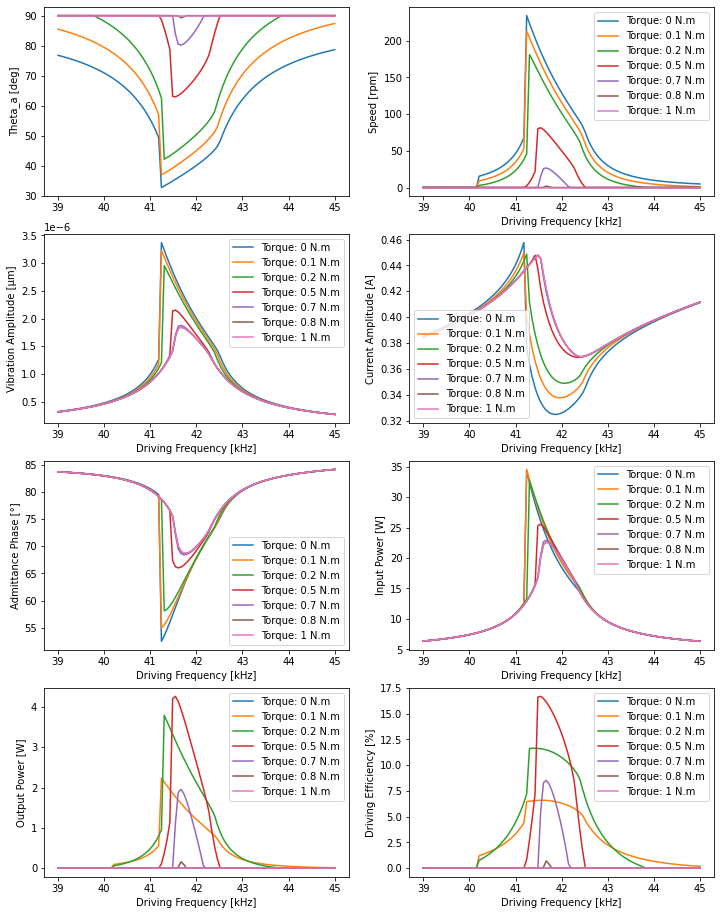

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize as opt

class USM_model:
  def __init__(self, m = 159e-3, d = 500, c = 10e9, cd = 10e-9, rd =5000, A = 0.25,
               h =  30e-3, r = 30e-3, k_r = 2e7, mu = 0.2,v_amp = 150, F_n = 170,
               T = 0, phase =1, tempMin = 20,  r_b = 30e-3, r_a = 10e-3,l = 20e-3,
               ru = 8400, sigma = 5.67e-8, h_c = 100, e = 0.8, s = 0.2e3, dt = 0,
              freq = 40, temp = 20, targetSpeed = 100 ):
    
    self.m0 = m*A**2        # modal mass
    self.d0 = d*A**2       # modal damping
    self.c0 = c*A**2       # modal stiffness
    self.C = c
    self.D = d
    self.M = m
    self.cd = cd      # damped capacitance
    self.rd = rd      # damped resistance
    self.A = A        # Coupling factor
    self.r = r        # radius of stator
    self.h = h        # height of contact surface
    self.k_r = k_r    # Rotor stiffness
    self.mu = mu      # Friction Coefficient

    self.v_amp = v_amp  # Voltage Amplitude
    self.F_n = F_n      # Preload
    self.T = T          # Load Torque
    self.T_max = self.F_n*self.mu*self.r
    self.phase = 1      # phase
    self.lastSpeed = 0.0
    self.freq_action = 0

    self.pLoss = 0.0
    self.tempMin = tempMin
    self.dt = dt
    self.area = 2*np.pi*((r_b+r_a)*l + r_b**2 - r_a**2)
    self.mass = ru*np.pi*(r_b**2-r_a**2)*l
    self.sigma, self.e, self.s, self.h_c  = sigma, e, s, h_c

    self.freq = freq
    self.temp = temp
    self.targetSpeed = targetSpeed
    self.err = 0
    self.lastErr = 0
    self.speed_noise = 0
    self.action_noise = 0
    self.fail = 0
    
    self.lastEnergy = np.log10(np.abs(-self.targetSpeed)+1)

    freq_range = np.linspace(39,45,100)
    temp_range = np.linspace(20,60,100)
    speed_range = np.linspace(0,300,100)
    torque_range = np.linspace(0,1,100)
    err_range = np.linspace(-300,300,100)
    scaler = np.array([freq_range,temp_range,torque_range, speed_range,speed_range])
    self.mean_scaler = np.mean(scaler,axis=-1)
    self.max_scaler = np.max(scaler,axis=-1)
    self.min_scaler = np.min(scaler,axis=-1)

    self.std_scaler = np.sqrt(np.square(scaler - self.mean_scaler.reshape((-1,1))).sum(axis=-1)/len(freq_range))

  #def scale_obs(self,o):
  #    return (o - self.mean_scaler)/self.std_scaler*2

  def scale_obs(self,o):
      return (o - self.mean_scaler)/(self.max_scaler - self.min_scaler)*2

  def sample_bimodal(self, x_min,x_max):
    std_ = (x_max - x_min)/3
    a = np.random.normal(x_min,std_, 30)
    a = a[a >= x_min] 

    b = np.random.normal(x_max,std_, 30)
    b = b[b <= x_max] 

    c = np.random.choice([a[0],b[0]])
    return np.clip(c,x_min,x_max)

  def update_temp(self,pLoss=None):
    if pLoss == None:
      pLoss = self.pLoss
    powerFlow = pLoss - self.h_c*self.area*(self.temp-self.tempMin) -\
               self.sigma*self.e*self.area*((self.temp+273)**4 - (self.tempMin+273)**4)
    tempRate = powerFlow/self.mass/self.s
    self.temp += self.dt*tempRate
    self.temp = np.clip(self.temp,self.tempMin,60)
    return self.get_state(self.freq)  

  def func_amp(self,w0,*args):
    return_all, = args
    if w0 < -self.wf:
      theta_b = np.pi
      wf = self.wf
    else:
      theta_b = opt.brenth(self.func_thetaB,1e-7,np.pi,args=(w0))
      wf = w0*np.cos(theta_b)
    try:  
      theta_a = opt.brenth(self.func_thetaA,1e-7,np.pi/2,args=(w0,theta_b,wf))
    except:
      theta_a = np.pi/2
    F_N = self.k_r*(w0*(np.sin(2*theta_b)/2 + theta_b) - 2*wf*np.sin(theta_b))
    F_T = 2*self.mu*self.k_r*(self.h/self.r) *\
          (w0*(np.sin(2*theta_a)/2 -np.sin(2*theta_b)/4 + theta_a - theta_b/2) -\
          wf*(2*np.sin(theta_a)-np.sin(theta_b)))
    err= (self.A*self.v_amp)**2 - ((self.c-self.m*self.omega**2)*w0 + F_N)**2 -\
                                  (self.d*self.omega*w0 + F_T)**2
    if return_all:
      return [theta_a, theta_b, wf, F_N, F_T, err]
    else:
      return err 

  def func_thetaA(self,theta_a,*args):
    w0,theta_b,wf = args
    return self.T+self.T_max -\
     4*self.mu*self.k_r*self.r*(w0*np.sin(theta_a)-wf*theta_a)

  def func_thetaB(self,theta_b,*args):
    w0, = args
    return self.F_n -\
     2*self.k_r*w0*(np.sin(theta_b)-theta_b*np.cos(theta_b))

  def get_state(self,freq=None,return_all = False):
    #noi = freq+ self.action_noise*np.random.normal(0,1)
    #print(noi)
    if freq != None:    
        self.freq = freq

    self.omega = 2*np.pi*(self.freq)*1000
    self.c = self.c0*(1-0.0095*np.sqrt(self.temp-self.tempMin))
    self.d = self.d0*(1-0.08*np.sqrt(self.temp-self.tempMin))
    self.m = self.m0
    self.wf = -self.F_n/(2*np.pi*self.k_r)
    omega_n = np.sqrt((self.c + np.pi*self.k_r)/self.m)
    self.w0,r = opt.brenth(self.func_amp,1e-9,1e-5,args=(False),full_output=True)
    self.theta_a, self.theta_b, self.wf, self.F_N, self.F_T, err = self.func_amp(self.w0,True)
    
    self.speed = 60*self.omega*self.h*self.w0/(2*np.pi*self.r**2)*np.cos(self.theta_a)*(self.F_n > 0)* (self.T < self.F_n*self.mu*self.r)*\
            ~((self.omega < (1.03-0.06*self.T/self.T_max)*omega_n) & (self.lastSpeed < 0.1)) * (self.omega > 0.96*omega_n)
    self.speed = round(self.speed,2)
    theta0 = np.arctan2(self.d*self.omega*self.w0 + self.F_T, (self.c-self.m*self.omega**2)*self.w0 + self.F_N)
    if abs(err) > 1:
      print('freq: {}, speed: {}, FN: {}, FT: {}, w0: {}, wf: {},  theta_a: {}, err: {}'.format(freq,self.speed,self.F_N,self.F_T,self.w0,self.wf,self.theta_a,err))
    I = 1j*self.omega*self.w0*np.exp(-1j*theta0)*self.A + (1/self.rd + 1j*self.omega*self.cd)*self.v_amp
    I_amp = np.abs(I)
    I_phase = (np.angle(I,deg=True)  + 2 * 180) % (2 * 180)
    pIn = np.real(self.v_amp*I).clip(0)
    pOut = (self.speed/60*2*np.pi)*self.T

    FBV = self.w0*self.A/self.cd
    self.err = self.speed - self.targetSpeed

    if ((abs(self.err) - abs(self.lastErr)) > 10):
      self.fail = 1
    else:
      self.fail = 0
        
    self.lastSpeed = self.speed
    self.eff = pOut/pIn*100
    self.pLoss = pIn - pOut
    a = np.array([1e-2,1e-1,1e0])
    b =  np.array([1e-2,1e-3,1e-4])            
    energy = 10/300*np.abs(self.err) + 10/np.log10(300)*np.log10(np.abs(self.err)+1) #100*np.abs(self.err)/np.sqrt(self.err**2 + self.targetSpeed **2 +1)
    #eng_dif = 10*1/((err+1)) * derr/du = 10/(err+1)*(err - err(t-1)) ~ 10(1 - err(t-1)/err(t))
    #self.energyDiff = 0.1/((np.abs(self.err)+1))*(np.abs(self.err) - np.abs(self.lastErr))
    self.energyDiff = energy - self.lastEnergy
    self.energyDiff = self.energyDiff*(0.95+0.05*np.sign(self.err*self.lastErr + 1e-3)) if self.energyDiff < 0 else 1*self.energyDiff
    self.lastEnergy = energy
    self.lastErr = self.err
    if return_all:
      return np.array([self.theta_a, self.speed, self.w0, I_amp, I_phase,pIn, pOut, self.eff])
      #return np.array([self.freq, self.T, self.F_n, self.temp,self.speed,self.targetSpeed, self.eff])
    else:
      return np.array([self.freq, self.temp, self.T, self.speed, self.targetSpeed])

  def get_reward(self,action):
    #diff = self.lastSpeed - self.speed  if self.speed == 0 else 0
    #err = np.abs(self.err)
    #alpha = 25
    #rew = np.sqrt(err) if (err < alpha) else err - alpha + np.sqrt(alpha) 
    L = self.energyDiff + 2*self.lastEnergy
    return - 0.1*np.abs(action) - max(L,0)  #-self.fail*10 #+ 0.5*np.sign((action+ 1e-5)*(self.lastErr+1e-5))

  def reset(self,freq=None,temp=None, lastSpeed = 0, T = None, targetSpeed=None, return_all = False):
    self.lastSpeed = 0
    self.freq = self.sample_bimodal(39,45) if freq == None else freq
    self.temp = self.sample_bimodal(20,60) if temp == None else temp
    self.targetSpeed = self.sample_bimodal(0,300) if targetSpeed == None else targetSpeed
    self.lastEnergy = np.abs(-self.targetSpeed)**2
    self.T = self.sample_bimodal(0,1) if T == None else T
    #self.T = 0
    return self.get_state(self.freq) 

  def step_frequency(self,action):          
      #pi_gain = 0.01*action[0]
      #u =  pi_gain*self.err
      self.freq = self.freq + action[0]*2
      self.freq_action = action[0]
      self.freq = np.clip(self.freq,39,45)
      state = self.get_state(self.freq)
      #self.lastSpeed = state[2]
      return state, self.get_reward(action[0]*2), self.fail

  def set_state(self,targetSpeed=None,torque = None):
    if targetSpeed != None:
      self.targetSpeed = targetSpeed
    if torque != None:
      self.T = torque
    return self.get_state(self.freq) 

  def set_temp(self,temp):
    self.temp = temp
  
  def get_temp(self):
      return self.temp
  def get_targetSpeed(self):
      return self.targetSpeed
  def get_speed(self):
      return self.speed
  def get_torque(self):
      return self.T
  def set_torque(self,T):
      self.T = T

  def vary_param(self):
    self.c0 = self.C*self.A**2*(1+0.03*2*(np.random.random()-0.5))
    self.d0 = self.D*self.A**2*(1+0.03*2*(np.random.random()-0.5))
    self.m0 = self.M*self.A**2*(1+0.03*2*(np.random.random()-0.5))
      
  def set_noise(self,speed_noise,action_noise):
    self.speed_noise = speed_noise
    self.action_noise = action_noise 
  

def sweep_freq(freqs,return_all = False):
  states = []
  for freq in freqs:
    states.append(USM.get_state(freq,return_all))
  return np.array(states)

def sweep_freq_all(freqs):
  states = []
  for freq in freqs:
    states.append(USM.get_state(freq,return_all=True))
  return np.array(states)
fig, axs = plt.subplots(4, 2,figsize=(12,16))
freqs = np.linspace(45,39,100)
for T in [0,0.1,0.2,0.5,0.7,0.8,1]:
  print(T)
  USM = USM_model(T=T)
  states = sweep_freq_all(freqs)
  axs[0,0].plot(freqs,states[:,0]*180/np.pi, label='Torque: {} N.m'.format(T))
  for i in range(1,states.shape[1]):
    axs[i//2,i%2].plot(freqs,states[:,i], label='Torque: {} N.m'.format(T))
    axs[i//2,i%2].legend()
    axs[i//2,i%2].set_xlabel('Driving Frequency [kHz]')
#axs[0,0].legend()
axs[0,0].set_ylabel('Theta_a [deg]')
axs[0,1].set_ylabel('Speed [rpm]')
axs[1,0].set_ylabel('Vibration Amplitude [μm]')

axs[1,1].set_ylabel('Current Amplitude [A]')
axs[2,0].set_ylabel('Admittance Phase [°]')
axs[2,1].set_ylabel('Input Power [W]')
axs[3,0].set_ylabel('Output Power [W]')
axs[3,1].set_ylabel('Driving Efficiency [%]')



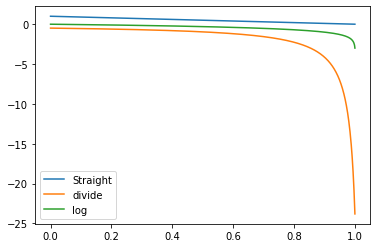

In [ ]:
x = np.arange(0,1,0.001)
y1 = 1-x
y2 = 0.5/(x-1.02)
y3 = np.log10((1-x+1e-5))

plt.plot(x,y1,label='Straight')
plt.plot(x,y2,label='divide')
plt.plot(x,y3,label='log')
plt.legend()

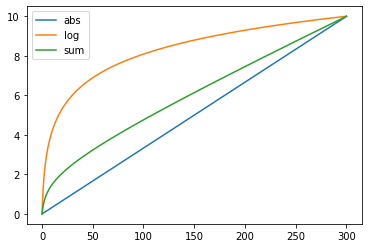

In [ ]:
xTarg = 0
x = np.arange(0,301,1)
err = x - xTarg
Rew = 10*np.log10(np.abs(err)+1)
rew = 10*np.abs(err)/np.sqrt(err**2 + xTarg **2 +1)
#plt.plot(err,0.18*np.abs(err),label="abs")

#plt.plot(err, 10*np.log10(10*np.abs(err) * np.exp(0.0001*np.square(err)) + 1),label='Sum')
plt.plot(err, 10/300*np.abs(err),label='abs')
plt.plot(err, 10/np.log10(300)*np.log10(np.abs(err)+1),label='log')

plt.plot(err, 7/300*np.abs(err) + 3/np.log10(300)*np.log10(np.abs(err)+1),label="sum")

plt.legend()

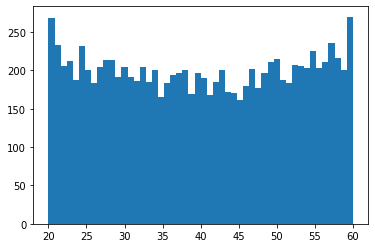

In [ ]:
def sample_bimodal(x_min,x_max):
    std_ = (x_max - x_min)/2.5
    a = np.random.normal(x_min,std_, 30)
    a = a[a >= x_min] 

    b = np.random.normal(x_max,std_, 30)
    b = b[b <= x_max] 

    c = np.random.choice([a[0],b[0]])
    return np.clip(c,x_min,x_max)

X = []
for i in range(10000):
  X.append(sample_bimodal(20,60))
plt.hist(X,bins=50);

20 244.02
30 293.02
40 311.8
50 325.8
60 336.58


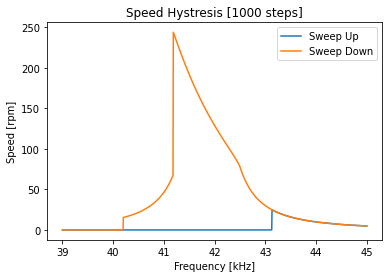

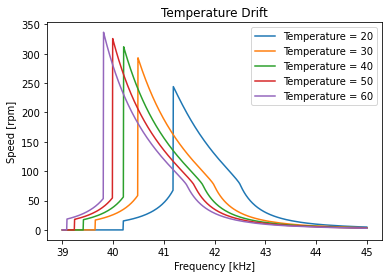

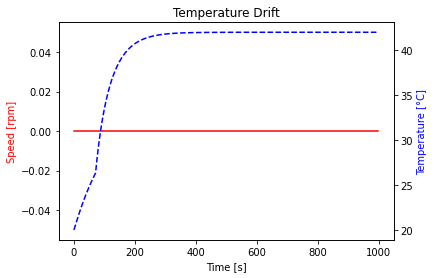

In [ ]:
USM = USM_model(T=0.)

n = 1000
freqs_up = np.linspace(39,45,n) 
freqs_down = np.linspace(45,39,n) 

speeds_up = sweep_freq(freqs_up)[:,3]
speeds_down = sweep_freq(freqs_down)[:,3]
plt.figure()
plt.plot(freqs_up,speeds_up,label='Sweep Up')
plt.plot(freqs_down,speeds_down,label='Sweep Down')
plt.xlabel('Frequency [kHz]');
plt.ylabel('Speed [rpm]');
plt.title('Speed Hystresis [' + str(n) + ' steps]');
plt.legend();

USM = USM_model(T=0.)

freqs = np.linspace(45,39,1000)
temps = [20,30,40,50,60]
plt.figure()
for temp in temps:
  USM.set_temp(temp)
  speeds = sweep_freq(freqs)[:,3]
  print(temp,max(speeds))
  plt.plot(freqs,speeds,label='Temperature = ' + str(temp))
plt.xlabel('Frequency [kHz]');
plt.ylabel('Speed [rpm]');
plt.title('Temperature Drift');
plt.legend();

dt = 1
USM.dt = dt
t = 0
speeds = []
times = []
temps = []
freq = 40.7
USM.reset(temp=20,freq=freq,lastSpeed=0)
for i in range(1000):
  state = USM.get_state(freq)
  speed,temp = state[3],state[1]
  temps.append(temp)
  speeds.append(speed)
  times.append(t)
  USM.update_temp()
  t+= dt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(times, speeds, 'r-')
ax2.plot(times, temps, 'b--')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Speed [rpm]', color='r')
ax2.set_ylabel('Temperature [°C]', color='b')
ax1.set_title('Temperature Drift')
plt.show()


In [ ]:
# m -> No. Features  n -> No. Samples
# Y -> (m,n)  X -> (m,n)  A -> (m,m)  B -> (m,1)   U -> (1,n) 
#Y = AX+BU 
# min |(Y - AX+BU)|
#Grad_A =  -2*(Y-AX+BU)*XT  -> (m,m)
#Grad_B = -2*(Y-AX+BU)*UT  -> (m,1)
# A = A + alpha*Grade_A
# B = B + alpha*Grade_B


In [ ]:
from numpy.core.fromnumeric import repeat
"""## Soft Actor Critic

#### Spinningup Implementation
"""


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
from copy import deepcopy
import itertools
from torch.optim import Adam

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


LOG_STD_MAX = 2
LOG_STD_MIN = -20

class SquashedGaussianMLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        self.net = mlp([obs_dim] + list(hidden_sizes), activation, activation)
        self.mu_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.act_limit = torch.as_tensor(act_limit, dtype=torch.float32)

    def forward(self, obs, deterministic=False, with_logprob=True):
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        log_std = self.log_std_layer(net_out)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)

        # Pre-squash distribution and sample
        pi_distribution = Normal(mu, std)
        if deterministic:
            # Only used for evaluating policy at test time.
            pi_action = mu
        else:
            pi_action = pi_distribution.rsample()

        if with_logprob:
            # Compute logprob from Gaussian, and then apply correction for Tanh squashing.
            # NOTE: The correction formula is a little bit magic. To get an understanding 
            # of where it comes from, check out the original SAC paper (arXiv 1801.01290) 
            # and look in appendix C. This is a more numerically-stable equivalent to Eq 21.
            # Try deriving it yourself as a (very difficult) exercise. :)
            logp_pi = pi_distribution.log_prob(pi_action).sum(axis=-1)
            logp_pi -= (2*(np.log(2) - pi_action - F.softplus(-2*pi_action))).sum(axis=1)
        else:
            logp_pi = None

        pi_action = torch.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi


class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [10], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPClassifierFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.z = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs, act):
        z = torch.sigmoid(self.z(torch.cat([obs, act], dim=-1)))
        return torch.squeeze(z, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, obs_dim, act_dim, act_limit, hidden_sizes=((64,64),(64,64)),
                 activation=(nn.ReLU,nn.ReLU)):
        super().__init__()

        # build policy and value functions
        self.pi = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes[0], activation[0], act_limit)
        self.q1 = MLPQFunction(obs_dim, act_dim, hidden_sizes[1], activation[1])
        self.lc = MLPClassifierFunction(obs_dim, act_dim, hidden_sizes[2], activation[2])

    def act(self, obs, deterministic=False):
        with torch.no_grad():
            a, _ = self.pi(obs, deterministic, False)
            return a.numpy()

class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for SAC agents.
    """

    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.fail_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs,fail):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.fail_buf[self.ptr] = fail
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     fail=self.fail_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

class SAC:
    """
    Soft Actor-Critic (SAC)


    Args:
        env_fn : A function which creates a copy of the environment.
            The environment must satisfy the OpenAI Gym API.

        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, a ``q1`` module, and a ``q2`` module.
            The ``act`` method and ``pi`` module should accept batches of 
            observations as inputs, and ``q1`` and ``q2`` should accept a batch 
            of observations and a batch of actions as inputs. When called, 
            ``act``, ``q1``, and ``q2`` should return:

            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.
            ``q1``       (batch,)          | Tensor containing one current estimate
                                           | of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ``q2``       (batch,)          | Tensor containing the other current 
                                           | estimate of Q* for the provided observations
                                           | and actions. (Critical: make sure to
                                           | flatten this!)
            ===========  ================  ======================================

            Calling ``pi`` should return:

            ===========  ================  ======================================
            Symbol       Shape             Description
            ===========  ================  ======================================
            ``a``        (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.
            ``logp_pi``  (batch,)          | Tensor containing log probabilities of
                                           | actions in ``a``. Importantly: gradients
                                           | should be able to flow back into ``a``.
            ===========  ================  ======================================

        ac_kwargs (dict): Any kwargs appropriate for the ActorCritic object 
            you provided to SAC.

        seed (int): Seed for random number generators.

        steps_per_epoch (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.

        epochs (int): Number of epochs to run and train agent.

        replay_size (int): Maximum length of replay buffer.

        gamma (float): Discount factor. (Always between 0 and 1.)

        polyak (float): Interpolation factor in polyak averaging for target 
            networks. Target networks are updated towards main networks 
            according to:

            .. math:: \\theta_{\\text{targ}} \\leftarrow 
                \\rho \\theta_{\\text{targ}} + (1-\\rho) \\theta

            where :math:`\\rho` is polyak. (Always between 0 and 1, usually 
            close to 1.)

        lr (float): Learning rate (used for both policy and value learning).

        alpha (float): Entropy regularization coefficient. (Equivalent to 
            inverse of reward scale in the original SAC paper.)

        batch_size (int): Minibatch size for SGD.

        start_steps (int): Number of steps for uniform-random action selection,
            before running real policy. Helps exploration.

        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.

        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.

        num_test_episodes (int): Number of episodes to test the deterministic
            policy at the end of each epoch.

        max_ep_len (int): Maximum length of trajectory / episode / rollout.

        logger_kwargs (dict): Keyword args for EpochLogger.

        save_freq (int): How often (in terms of gap between epochs) to save
            the current policy and value function.

    """
    def __init__(self, env_type = "SIM", obs_dim = 4, act_dim = 1, act_limit = 1,
                 buffer_size = int(1e6), hidden_sizes = (64,64),  gamma=0.99,
                 polyak=0.995, lr=1e-3, alpha=0.2, alpha_rate=0.99,gamma_rate = 0.99,
                 activation=(nn.ReLU, nn.ReLU),seed=1):
    
        self.replay_buffer = ReplayBuffer(obs_dim = obs_dim, act_dim = act_dim, size= buffer_size)
        self.env_type = env_type
        if env_type == 'SIM':
            
            self.env = USM_model(dt=1)
            self.scale_obs = self.env.scale_obs
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        self.obs_dim, self.act_dim = obs_dim, act_dim    
        self.gamma, self.polyak = gamma, polyak
        self.alpha,self.alpha_rate = alpha, alpha_rate
        self.gamma_rate = gamma_rate
        self.act_limit = act_limit
        
        # Create actor-critic module and target networks
        self.ac = MLPActorCritic(obs_dim, act_dim, act_limit, hidden_sizes = hidden_sizes, activation = activation)
        self.ac_targ = deepcopy(self.ac)
        # Freeze target networks with respect to optimizers (only update via polyak averaging)
        for p in self.ac_targ.parameters():
            p.requires_grad = False
          
        # List of parameters for both Q-networks (save this for convenience)
        #self.q_params = itertools.chain(self.ac.q1.parameters(), self.ac.q2.parameters())
        self.q_params = itertools.chain(self.ac.q1.parameters())
        self.lc_params = itertools.chain(self.ac.lc.parameters())

        # Set up optimizers for policy and q-function
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=lr/2)
        self.q_optimizer = Adam(self.q_params, lr=lr)
        self.lc_optimizer = Adam(self.lc_params, lr=lr)

    
    # Set up function for computing SAC Q-losses
    def compute_loss_q(self,data):
        o, a, r, o2 = data['obs'], data['act'], data['rew'], data['obs2']
        q1 = self.ac.q1(o,a)
        #q1 = torch.mean(q1)
        #q2 = self.ac.q2(o,a)

        # Bellman backup for Q functions
        with torch.no_grad():
            # Target actions come from *current* policy
            a2, logp_a2 = self.ac.pi(o2)

            # Target Q-values
            q1_pi_targ = self.ac_targ.q1(o2, a2)
            #q2_pi_targ = self.ac_targ.q2(o2, a2)
            #q_pi_targ = torch.min(q1_pi_targ, q2_pi_targ)
            q_pi_targ = torch.min(q1_pi_targ,dim=1).values
            #print(q1_pi_targ.shape,q_pi_targ.shape,logp_a2.shape)
            #backup = r.unsqueeze(dim=1) + self.gamma * (q1_pi_targ - self.alpha * logp_a2.unsqueeze(dim=1))
            backup = r + self.gamma * (q_pi_targ - self.alpha * logp_a2)

            backup = torch.reshape(backup,(-1,1))

        # MSE loss against Bellman backup
        loss_q1 = ((q1 - backup)**2).mean()
        #loss_q2 = ((q2 - backup)**2).mean()
        #loss_q = loss_q1 + loss_q2
        loss_q = loss_q1

        # Useful info for logging
        #q_info = dict(Q1Vals=q1.detach().numpy(),
        #              Q2Vals=q2.detach().numpy())
        q_info = dict(Q1Vals=loss_q.detach().numpy())
        return loss_q, loss_q.detach().numpy()

    def compute_loss_lc(self,data):
        o, a, fail = data['obs'], data['act'], data['fail']
        y_pred = self.ac.lc(o,a)
        w = torch.abs(fail - 0.1)
        loss_lc = -torch.multiply(w,(torch.multiply(fail,torch.log(y_pred + 1e-5)) + torch.multiply((1-fail),torch.log(1-y_pred +1e-5)))).mean()
        #print(loss_lc)
        lossLC_info = dict(Q1Vals=loss_lc.detach().numpy())
      
        return loss_lc,loss_lc.detach().numpy()
        
    def compute_loss_pi(self,data):
        o = data['obs']
        #o2 = data['obs2']

        pi, logp_pi = self.ac.pi(o)
        
        #L_pi = torch.min(L1_pi, L2_pi)
        q1_pi = self.ac.q1(o, pi)
        fail = self.ac.lc(o,pi)

        #q2_pi = self.ac.q2(o, pi)
        #q_pi = torch.min(q1_pi, q2_pi)
        #err(-)*a(-) = + 

        q_pi = torch.min(q1_pi,dim=1).values #+ 0.1*torch.sign(torch.multiply(pi,o[:,-1]) + 1e-5) #+ (1/(fail-1.02) +1/1.02) #+ 1*torch.sign(torch.multiply(pi,o[:,-1]) + 1e-5) #- 5*(torch.clip(2*fail-1,min=0))# + 0.5*torch.sign(torch.multiply(pi,o[:,-1]) + 1e-5) torch.log10(torch.clip(1-2*fail,min=0))
        #print("Q: {} -- logpi:  {} ".format(q_pi,logp_pi))
        # Entropy-regularized policy loss
        loss_pi = (self.alpha * logp_pi - q_pi).mean()

        # Useful info for logging
        pi_info = dict(LogPi=loss_pi.detach().numpy())

        return loss_pi, loss_pi.detach().numpy()

    def update(self,data):
        # First run one gradient descent step for Q1 and Q2
        self.q_optimizer.zero_grad()
        loss_q, self.q_info = self.compute_loss_q(data)
        loss_q.backward()
        self.q_optimizer.step()

        self.lc_optimizer.zero_grad()
        loss_lc, self.lc_info = self.compute_loss_lc(data)
        loss_lc.backward()
        self.lc_optimizer.step()
    # Set up function for computing SAC pi loss

        # Freeze Q-networks so you don't waste computational effort 
        # computing gradients for them during the policy learning step.
        for p in self.q_params:
            p.requires_grad = False
        for p in self.lc_params:
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        self.pi_optimizer.zero_grad()
        loss_pi, self.pi_info = self.compute_loss_pi(data)
        loss_pi.backward()
        self.pi_optimizer.step()

        # Unfreeze Q-networks so you can optimize it at next DDPG step.
        for p in self.q_params:
            p.requires_grad = True
        for p in self.lc_params:
            p.requires_grad = True

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(self.ac.q1.parameters(), self.ac_targ.q1.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)
                
    def update_alpha(self):
        self.alpha *= self.alpha_rate
        self.alpha = max(0.01,self.alpha)

    def update_gamma(self):
        self.gamma *= self.gamma_rate
        self.gamma = max(0.1,self.gamma)
        #self.gamma = np.random.random()

    def get_alpha(self):
        return self.alpha
    
    def get_action(self,o, deterministic=False):
        return self.ac.act(torch.as_tensor(o, dtype=torch.float32), 
                      deterministic)
    def get_q(self,o):
      o = torch.as_tensor(o, dtype=torch.float32)
      a = self.get_action(o)
      a = torch.as_tensor(a, dtype=torch.float32)
      q1_ = self.ac.q1(o, a)
      #q2_ = self.ac.q2(o, a)
      #q_ = torch.min(q1_, q2_)
      q_ = torch.max(q1_)
      return q_.detach().numpy()
    
    
    def train_agent(self, batch_size=128, start_steps=-1, max_ep_len=30,
                    num_eps=1000, update_every=1, alpha_rate=0.995, eval_every = 250):
    
        # Random seed for numpy and torch
        #env.start()
        # Prepare for interaction with environment
        total_steps = max_ep_len * num_eps
        ep = 1
        
        o,ep_ret, ep_len = self.env.reset(), 0, 0 
        LOGs = []
        losses = []
        #states = []
        #actions = []
        o = self.scale_obs(o)
        q0 = self.get_q(o)
        # Main loop: collect experience in env and update/log each epoch
        for t in range(total_steps):
            # Until start_steps have elapsed, randomly sample actions
            # from a uniform distribution for better exploration. Afterwards, 
            # use the learned policy. 
            if t > start_steps:
                a = self.get_action(o)
            else:
                a = 2*(np.random.random(self.act_dim) -0.5)*self.act_limit
      
            # Step the env
            o2, r, fail = self.env.step_frequency(a)

            #states.append(o2)
            #actions.append(a)
            o2 = self.scale_obs(o2)
            ep_ret += r
            ep_len += 1

            # Store experience to replay buffer
            self.replay_buffer.store(o, a, r, o2,fail)
      
            # Super critical, easy to overlook step: make sure to update 
            # most recent observation!
            #o = self.env.update_temp()
            #o = self.scale_obs(o)
            o = o2

            # Update handling
            if t % update_every == 0:
                #env.stop()
                for j in range(update_every):
                    batch = self.replay_buffer.sample_batch(batch_size)
                    self.update(data=batch)
                    losses.append([self.q_info,self.lc_info,-self.pi_info])    

                #env.start()
            # End of trajectory handling
            if (ep_len == max_ep_len):
                #plot_eval(np.array(states),np.array(actions))
                #states=[]
                #actions=[]
                if ep % eval_every == 0:
                    self.run_evals_ep(ep)
                if ep % 10 == 0:
                  print("Episode: {} --> Temp: {} --> TargetSpeed/Speed: {}/{} --> Torque: {}--> reward: {} --> Q0: {}".format(ep,self.env.get_temp(),self.env.get_targetSpeed(), self.env.get_speed(), self.env.get_torque(),ep_ret,q0))
                ep += 1
                LOGs.append(np.array([ep,self.env.get_temp(),self.env.get_torque(),self.env.get_targetSpeed(),ep_ret,self.env.get_speed(),q0]))
                #self.env.set_noise(np.abs(np.random.normal())*50,np.abs(np.random.normal())*0.05)
                o, ep_ret, ep_len = self.env.reset(), 0, 0 # targetSpeed=targetSpeeds[ep]
                o = self.scale_obs(o)
                q0 = self.get_q(o)
                self.update_alpha()
                self.update_gamma()
                
        return np.array(LOGs),np.array(losses)
    
    def load_network(self, env_type='sim'):
        self.ac.pi.load_state_dict(torch.load('pi_' + env_type))
        self.ac.q1.load_state_dict(torch.load('q1_' + env_type))
        self.ac.lc.load_state_dict(torch.load('lc_' + env_type))
        
    def save_network(self, env_type='sim'):
        torch.save(self.ac.pi.state_dict(),'pi_'+env_type)
        torch.save(self.ac.q1.state_dict(),'q1_'+env_type)
        torch.save(self.ac.lc.state_dict(),'lc_'+env_type)
        
    def eval_agent(self, targetSpeeds, torques = None, freq = None,temp = None):
        #env.dt = dt
        o = self.env.reset(freq=freq,temp=temp,T=torques[0], targetSpeed = targetSpeeds[0])
        states = [o]
        actions = [np.zeros(1)]
        for i in range(len(targetSpeeds)):
          o = self.env.set_state(targetSpeed = targetSpeeds[i],torque = torques[i])
          o = self.scale_obs(o)
          a = self.get_action(o, deterministic=True)
          actions.append(a*2)
          o, _,_ = self.env.step_frequency(a)
          states.append(o)
          #if i % 10 == 0:
          self.env.update_temp()

        states = np.array(states)
        self.plot_eval(states,actions)
        actions = np.array(actions).reshape(-1,1)
        return np.concatenate((states,actions),axis=-1)

    def run_evals_ep(self,ep,n = 100,freq=None,temp=None,T=0):
        #Constant Speed
        Speeds = np.arange(n+1).reshape(-1,1)
        torques = [T]*n
        for targetSpeed in [300,200,100,0]:
            targetSpeeds = [targetSpeed]*n
            speeds = self.eval_agent(targetSpeeds,torques,freq,temp)
            plt.suptitle('Speed Tracking -- Episode: ' + str(ep), y=0.95, fontsize=20,fontweight='bold')
            Speeds = np.concatenate((Speeds,speeds),axis=-1)
            #self.env.stop()
            #time.sleep(300)
            #self.env.start(amp=3,freq=42)
        #np.savetxt('gdrive/MyDrive/Sensor_bases_SAC_speed/eval_{}_target_{}_{}.txt'.format(ep,targetSpeed,self.env_type), Speeds, delimiter=',')

    def run_evals_full(self,seed,T=None):
    
        #Step Speed
        targetlevels = np.linspace(0,300, 7)
        targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
        targetSpeeds = []
        for level in targetlevels:
            targetSpeeds += [level]*50 
        torques = [T]*len(targetSpeeds)
        speeds = self.eval_agent(targetSpeeds,torques,temp=20)
        #np.savetxt('gdrive/MyDrive/Sensor_bases_SAC_speed/seed_{}_steppingTracking_{}.txt'.format(seed,self.env_type), speeds, delimiter=',')
        #Sinusoidal Speed
        N = 1000    #total steps
        n = 10      #num cycles   
        targetSpeeds = 150+150*np.sin(np.linspace(0,n,N)*2*np.pi)
        torques = [T]*len(targetSpeeds)
        speeds = self.eval_agent(targetSpeeds,torques,temp=20)
        #np.savetxt('gdrive/MyDrive/Sensor_bases_SAC_speed/seed_{}_sinTracking_{}.txt'.format(seed,self.env_type), speeds, delimiter=',')
    
    def plot_training_logs(self,seed,LOGS,losses):
        #np.savetxt('gdrive/MyDrive/Sensor_bases_SAC_speed/seed_{}_logs_{}.txt'.format(seed,self.env_type), LOGS, delimiter=',')
        Ep_ret = LOGS[:,-3]
        avg_ret = np.convolve(Ep_ret, np.ones(5), 'valid') / 5
        Err = np.abs(LOGS[:,-2] - LOGS[:,3])
        Avg_err = np.convolve(Err, np.ones(5), 'valid') / 5
        
        plt.figure(figsize=(16,12))
        
        plt.subplot(2,2,1)
        plt.plot(Ep_ret,label="Episode Reward");
        plt.plot(avg_ret, label="Average Reward");
        plt.plot(LOGS[:,-1], label="Expected Reward");
        plt.xlabel('Episode');
        plt.ylabel('Reward');
        plt.title('Learning Curve');
        plt.legend()
        
        plt.subplot(2,2,2)
        plt.plot(LOGS[:,3],label='Target Speed');
        plt.plot(LOGS[:,-2],label='Actual Speed');
        plt.plot(Avg_err,label='Moving Average Err');
        plt.xlabel('Episode');
        plt.ylabel('Speed [rpm]');
        plt.legend()
        
        plt.subplot(2,2,3)
        plt.plot(LOGS[:,1]);
        plt.xlabel('Episode');
        plt.ylabel('USM Temperature [°C]');
        
        plt.subplot(2,2,4)
        plt.plot(LOGS[:,2]);
        plt.xlabel('Episode');
        plt.ylabel('Load Torque [N.m]');


        plt.figure(figsize=(8,12))
        plt.subplot(3,1,1)
        plt.plot(losses[:,0])
        plt.ylabel("Q-loss")

        plt.subplot(3,1,2)
        plt.plot(losses[:,1])
        plt.ylabel("LC-loss")


        plt.subplot(3,1,3)
        plt.plot(losses[:,2])
        plt.ylabel("Pi-loss")
        


    def plot_eval(self,states,actions):
        plt.figure(figsize=(16,12))
    
        #Plot 1
        plt.subplot(2,2,1)
        plt.plot(states[:,3],'r',label='Speed')
        plt.plot(states[:,4],'b--',label='TargetSpeed')
        plt.plot(abs(states[:,3]-states[:,4]), 'k',label = 'Speed Error')
        plt.xlabel('Step',fontweight='bold',fontsize=16)
        plt.ylabel('Speed [rpm]',fontweight='bold',fontsize=16)
        #plt.title('Constant Speed Tracking',fontweight='bold')
        plt.legend();
    

        ax1 = plt.subplot(2,2,2)
        ax1.plot(states[:,0])
        ax1.set_xlabel('Step',fontweight='bold',fontsize=16);
        ax1.set_ylabel('Driving Frequency [kHz]',fontweight='bold',fontsize=16);

        ax2 = ax1.twinx()
        ax2.plot((actions),'r--')
        ax2.set_ylabel('Frequency Action [kHz]',fontweight='bold',fontsize=16);
        
        #Plot 2
        plt.subplot(2,2,3)
        plt.plot(states[:,1])
        plt.xlabel('Step',fontweight='bold',fontsize=16);
        plt.ylabel('Temperature [°C]',fontweight='bold',fontsize=16);
        #plt.title('Constant Speed Tracking',fontweight='bold',);
        #plt.ylim([0,150])

        #Plot 4
        plt.subplot(2,2,4)
        plt.plot(states[:,2])
        plt.xlabel('Step',fontweight='bold',fontsize=16);
        plt.ylabel('Torque [N.m]',fontweight='bold',fontsize=16);

In [ ]:
0.5**10

0.0009765625

Episode: 10 --> Temp: 27.27274211495267 --> TargetSpeed/Speed: 108.58376292233032/0.0 --> Torque: 0.4543875695875649--> reward: -225.2736645683403 --> Q0: -27.292490005493164
Episode: 20 --> Temp: 20.17699588402908 --> TargetSpeed/Speed: 224.8926934365385/0.0 --> Torque: 0.5285204400387006--> reward: -339.906630765719 --> Q0: -42.597164154052734
Episode: 30 --> Temp: 38.31763976897706 --> TargetSpeed/Speed: 19.809085914430373/0.0 --> Torque: 0.5588323550600928--> reward: -119.43558101673952 --> Q0: -18.126588821411133
Episode: 40 --> Temp: 53.178754458644356 --> TargetSpeed/Speed: 199.38696627505857/0.0 --> Torque: 0.9670517753863926--> reward: -319.4645321397738 --> Q0: -55.330841064453125
Episode: 50 --> Temp: 50.87059289842266 --> TargetSpeed/Speed: 5.411269964644369/0.0 --> Torque: 0.7866771853577663--> reward: -79.10035802733582 --> Q0: -17.827465057373047
Episode: 60 --> Temp: 36.894827123854846 --> TargetSpeed/Speed: 173.8569657760903/0.0 --> Torque: 0.3697699158352087--> reward

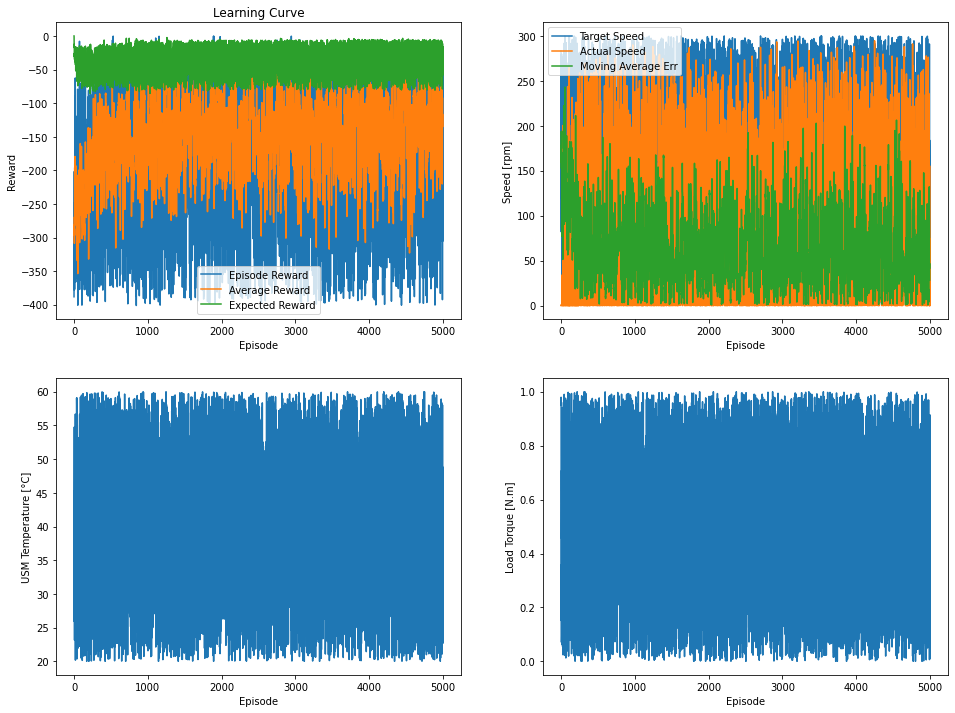

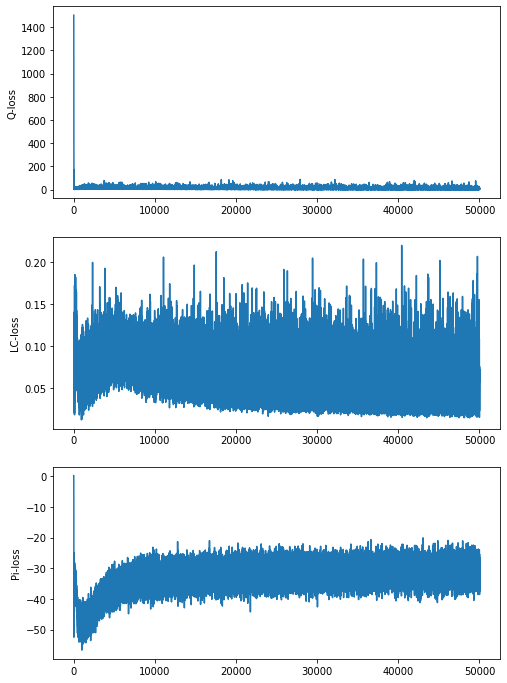

In [ ]:
# -*- coding: utf-8 -*-
"""SAC_USM_summary015082021.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dkO9jeq8YQvj1qT2-Jm-qK8GoS3Ih7ow
"""

# Commented out IPython magic to ensure Python compatibility.
#import numpy as np
#import matplotlib.pyplot as plt
#from evaluate import run_evals
import torch.nn as nn

obs_dim = 5
act_dim = 1
act_limit= [1]
buffer_size = int(1e5)
hidden_sizes = ([64]*2,[64]*4,[5])
activation=(nn.ReLU,nn.ReLU,nn.ReLU6)
agent_save = 'sim'#'sim_noise'
agent_load = None #'sim_noise' #'sim_speednoise'
agent_train = True
seed = 10

path = ""

#for seed in range(3):
  #env_type = 'SIM' #'EXP'
agent = SAC(env_type='SIM',obs_dim = obs_dim, act_dim = act_dim, act_limit= act_limit, polyak=0.99, buffer_size=buffer_size,
            alpha=0.5, alpha_rate = 1,lr=5e-3,hidden_sizes = hidden_sizes, gamma=0.5,gamma_rate=1, activation=activation,seed=seed)

if agent_load != None:
    agent.load_network(agent_load)
if agent_train:
    LOGS,losses = agent.train_agent(num_eps=5001, max_ep_len = 10, batch_size=64,update_every=10,eval_every=100000)
    agent.plot_training_logs('noise_{}'.format(seed),LOGS,losses)

    if agent_save != None:
        agent.save_network(agent_save)
#for i in [0,1,2,3,4,5]:
#  noise = i
#  agent.env.set_noise(0,noise/100)
#  agent.run_evals_full('action_noise_0{}'.format(noise))
#  agent.run_evals_ep('action_noise_0{}'.format(noise),n=1000,freq=39,temp=25)



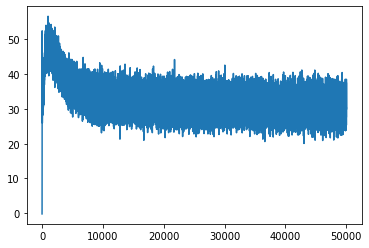

In [ ]:
plt.plot(-losses[:,2])

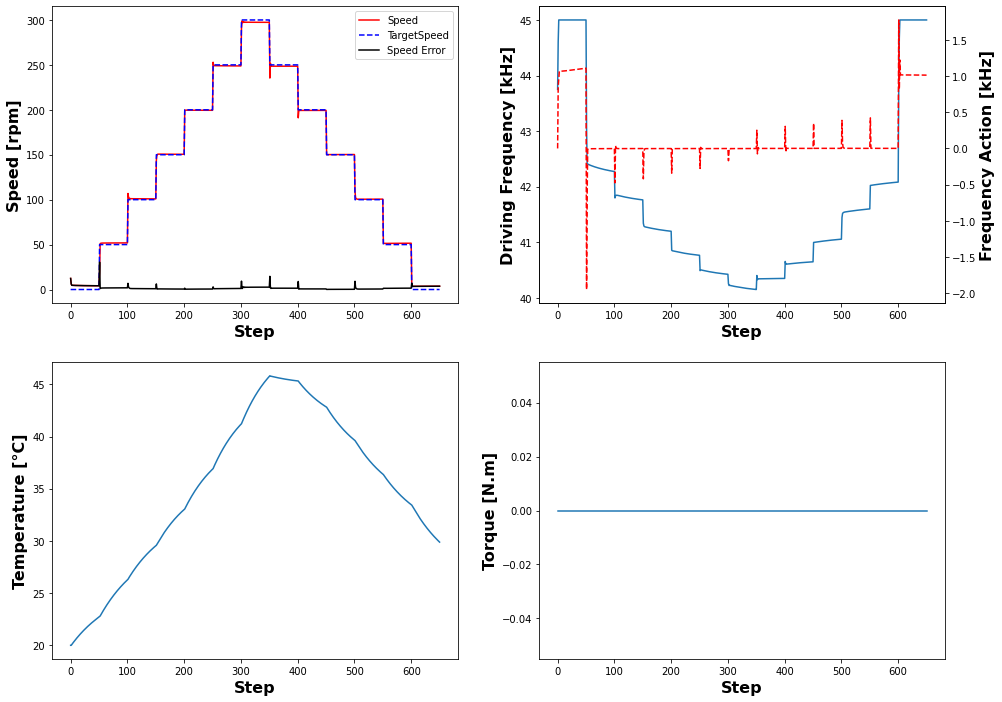

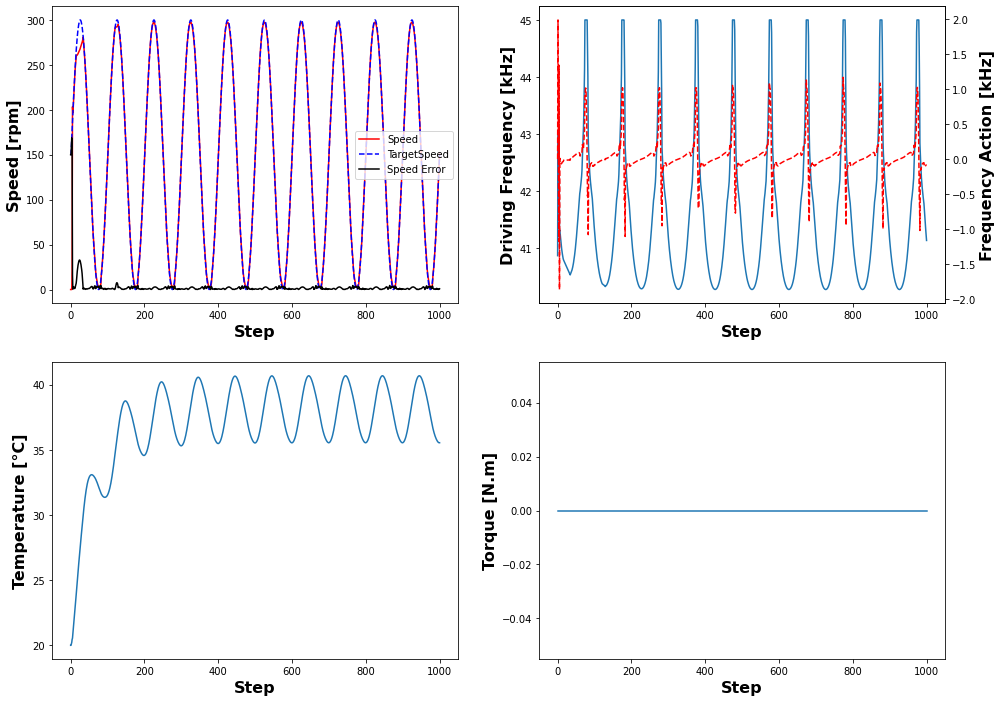

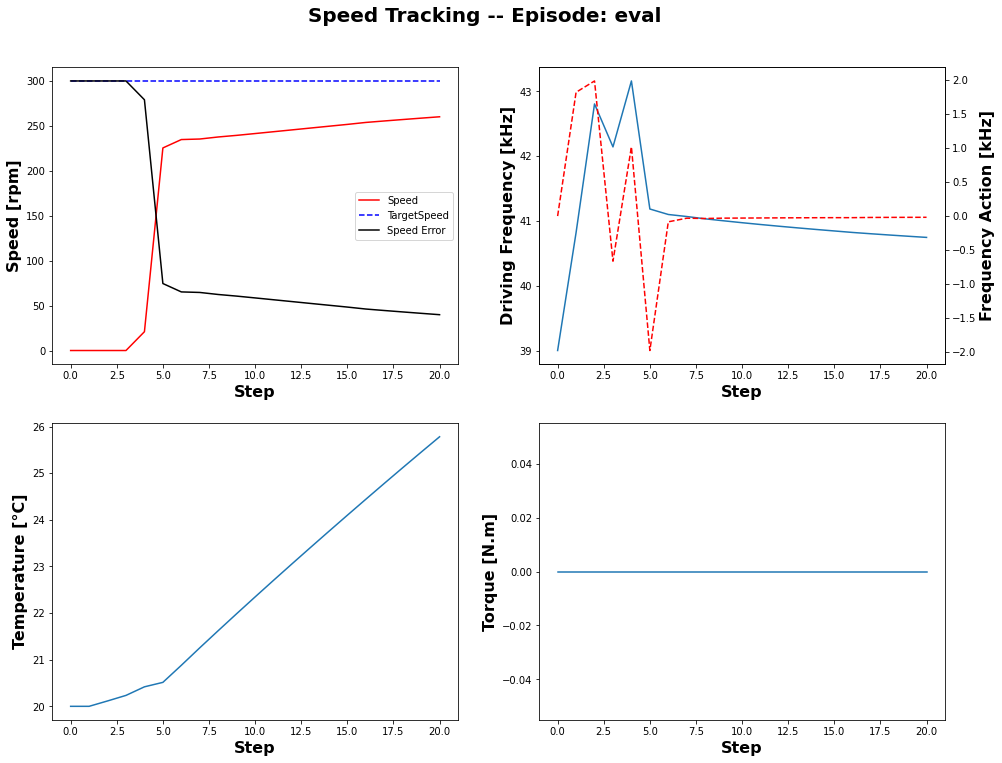

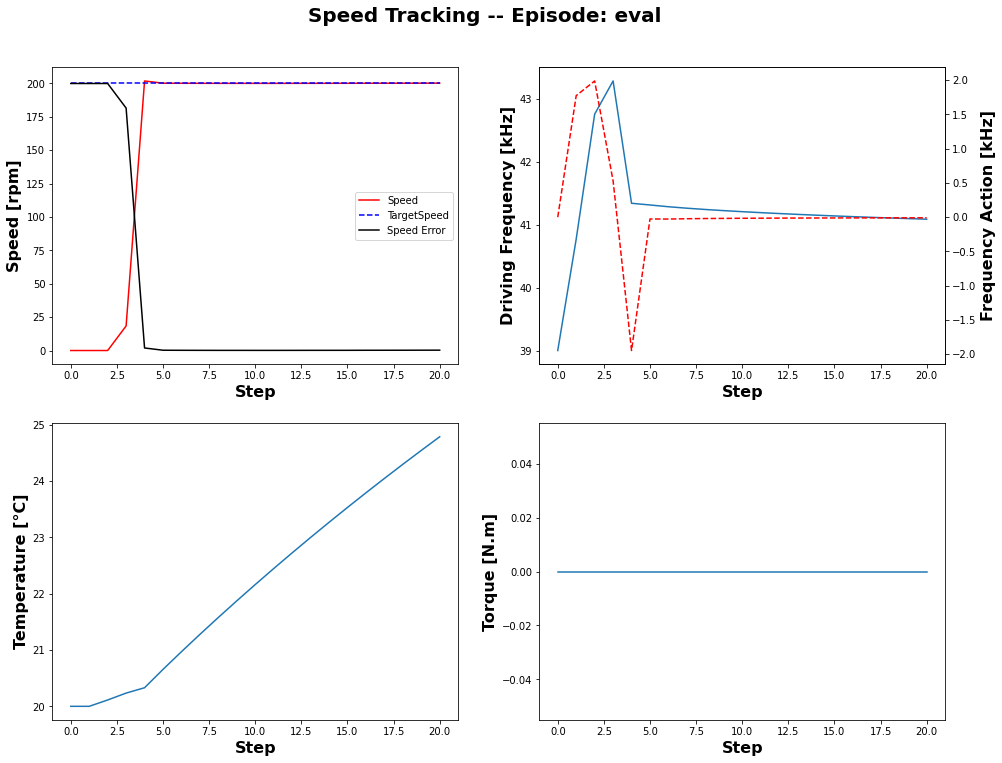

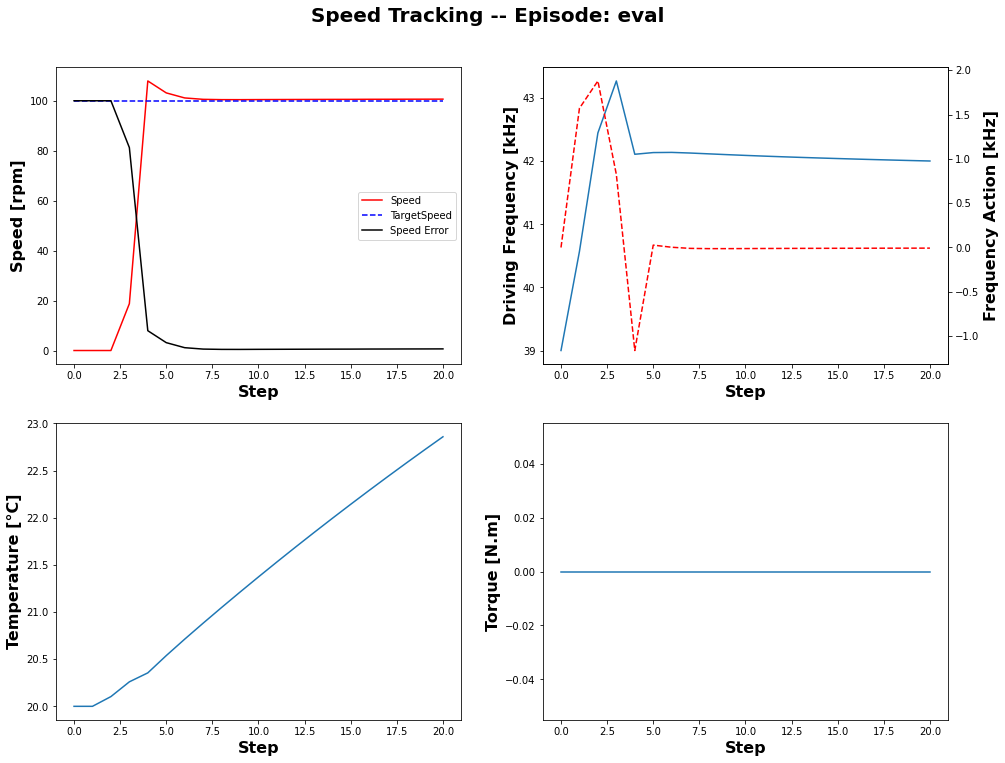

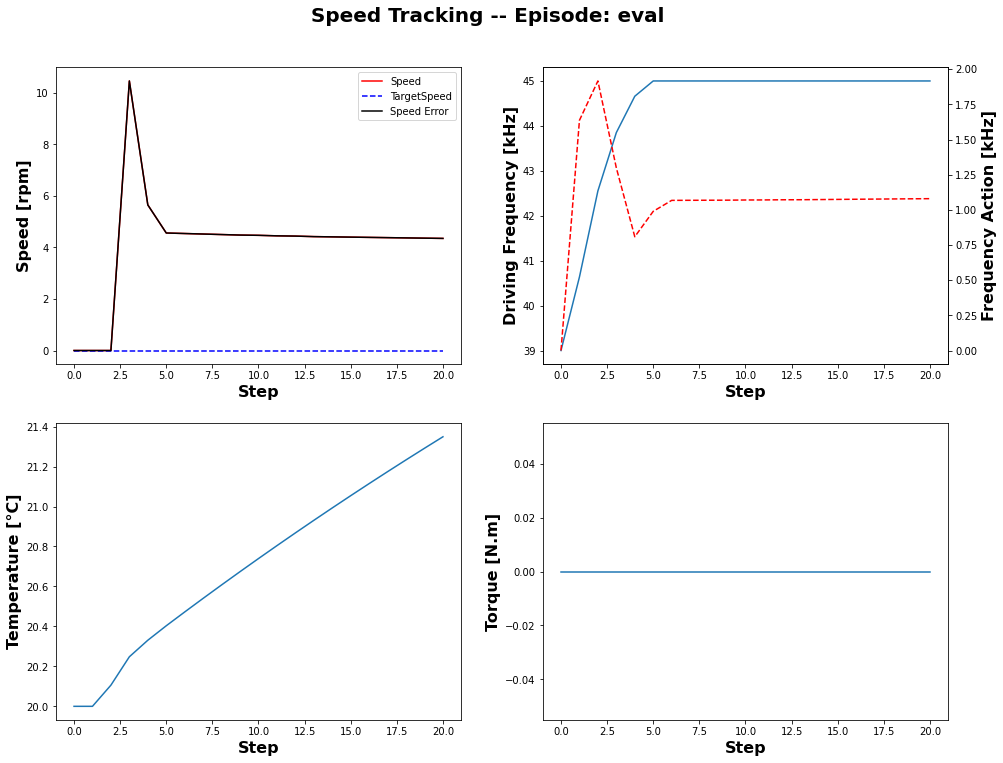

In [ ]:

agent.run_evals_full('all',T=0)
agent.run_evals_ep('eval',n=20,freq=39,temp=20,T=0)

0 1.5547146e-06
[ 43.23290837  20.           0.55         0.         300.        ]
0 0.0062978887
[ 41.82312346  20.10306117   0.48092931   0.         300.        ]
0 7.59427e-05
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.26901817
0 0.022803597
[ 40.8482494   27.9986438    0.87663427   0.         300.        ]
0 0.0030048415
[ 41.13674854  28.0769074    0.92961939   0.         300.        ]
0 0.0034477203
[ 42.05693959  28.26875639   0.9765937    0.         300.        ]
0 4.6264224e-05
[ 43.57644533  28.31289324   1.01681342   0.         300.        ]
0 5.1280093e-08
[ 45.          28.29276882   1.04964171   0.         300.        ]
0 1.1481657e-07
[ 45.          28.26115167   1.07455878   0

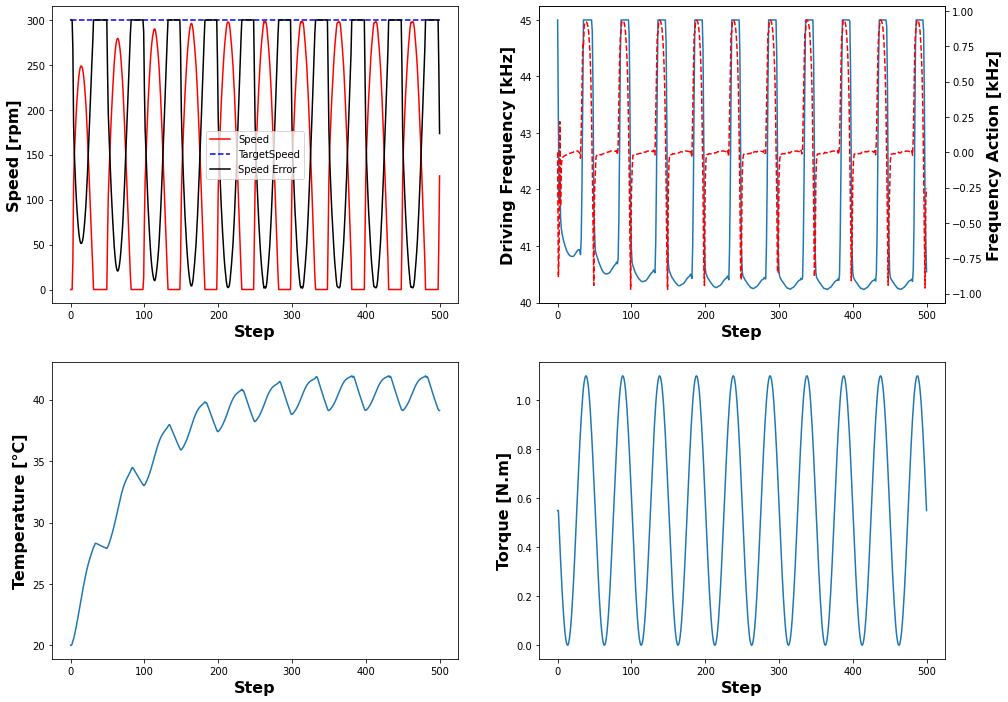

In [ ]:
N = 500
n = 10
targetSpeed = 300
T = 0.5
targetSpeeds = N*[targetSpeed]
Ts = 0.55-0.55*np.sin(np.linspace(0,n,N)*2*np.pi)
#Ts = N*[T]
#targetSpeeds = 15+ 15*np.sin(np.linspace(0,n,N)*2*np.pi)

o = agent.env.reset(freq=45,temp=20,T=Ts[0],targetSpeed=targetSpeeds[0])
states = [o]
actions = [np.zeros(1)]
for i in range(len(targetSpeeds)):
  o = agent.env.set_state(targetSpeed = targetSpeeds[i],torque = Ts[i])
  o = agent.scale_obs(o)
  a = agent.get_action(o, deterministic=True)
  fail_pred = agent.ac.lc(torch.as_tensor(o, dtype=torch.float32),torch.as_tensor(a, dtype=torch.float32)).detach().numpy()

  actions.append(a)

  o,_,fail = agent.env.step_frequency(a)
  print(fail,fail_pred)
  states.append(o)

  if o[3] == 0:
    print(states[-1])
  #if i % 10 == 0:
  agent.env.update_temp()

states = np.array(states)
agent.plot_eval(states,actions)
actions = np.array(actions).reshape(-1,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:605: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:605: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:605: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

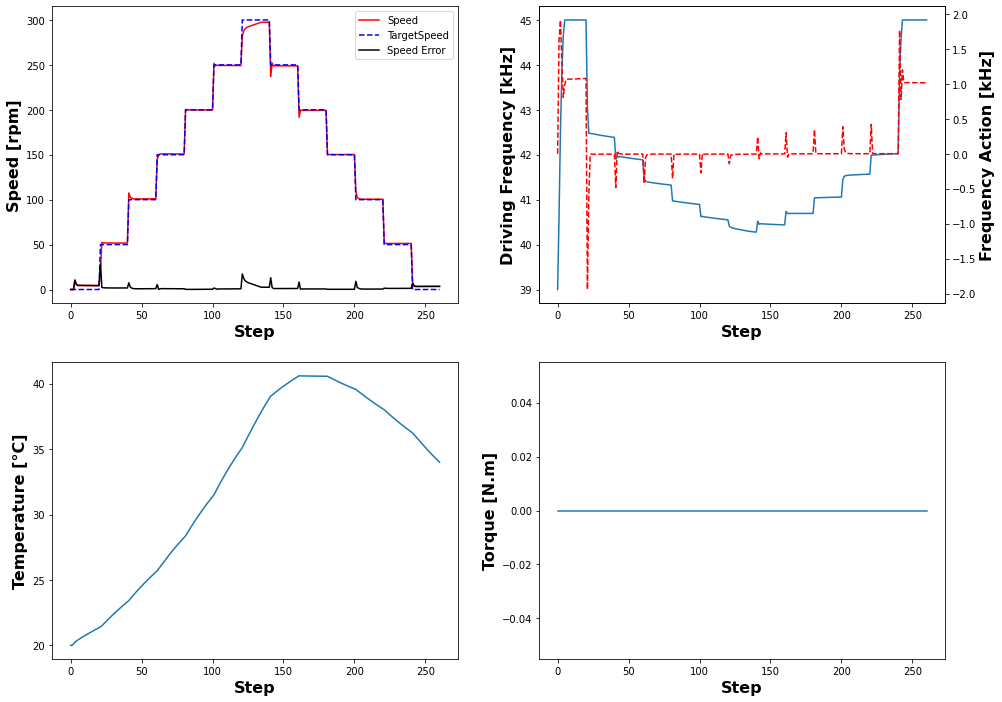

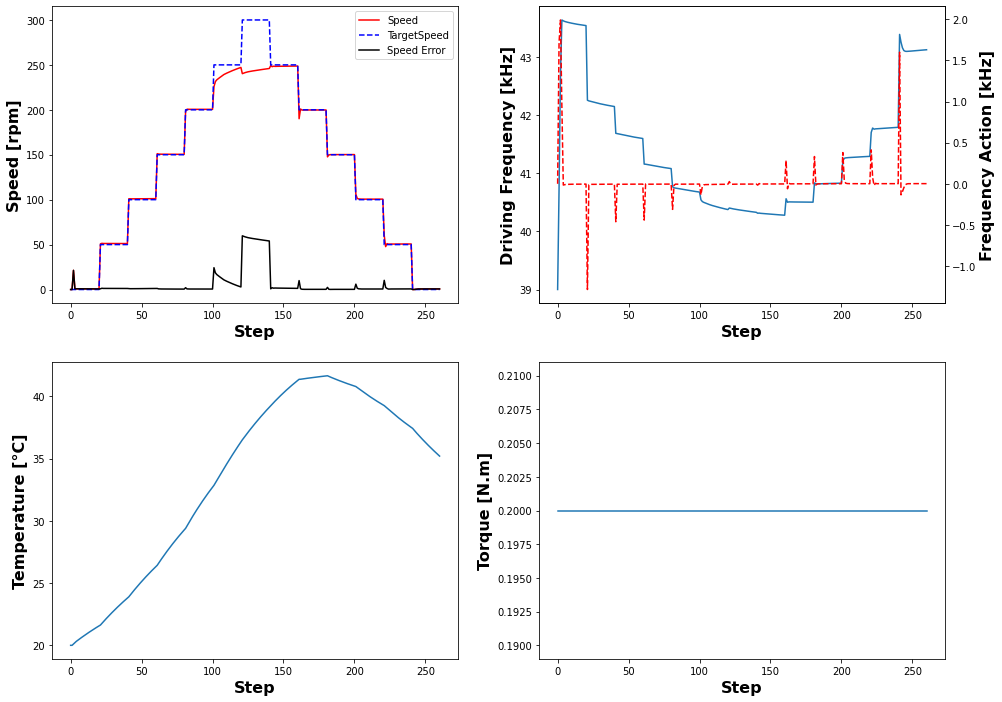

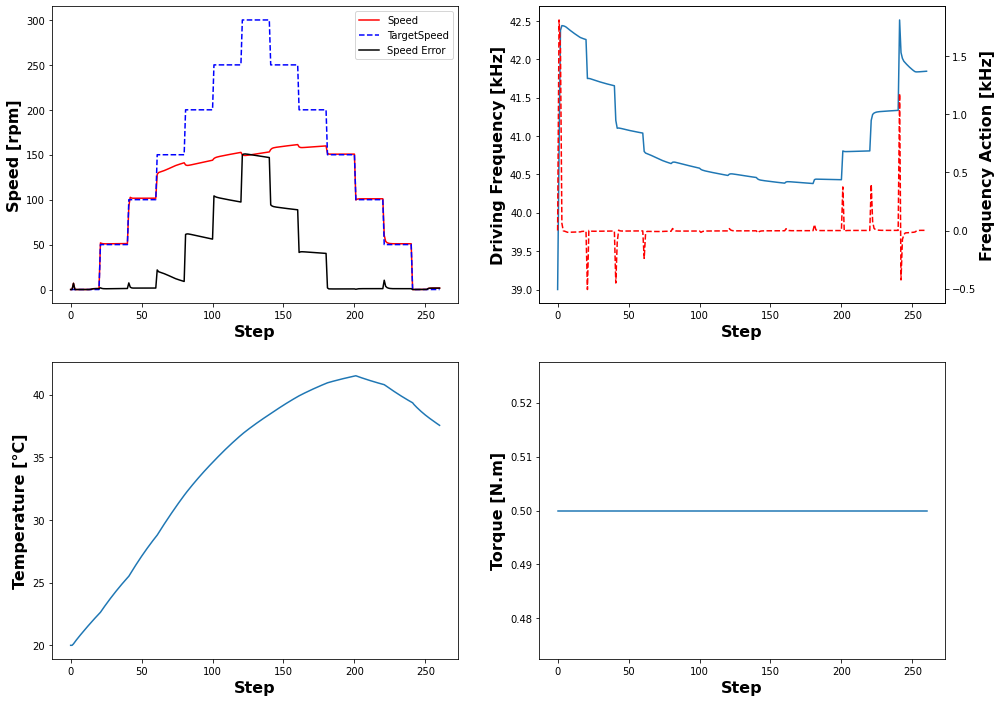

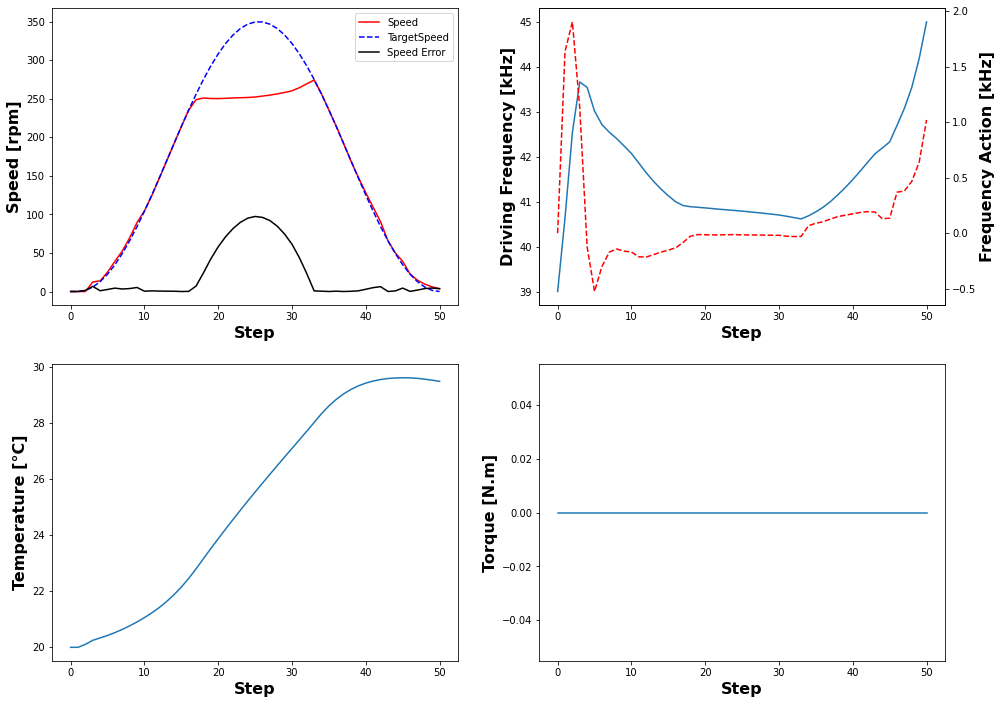

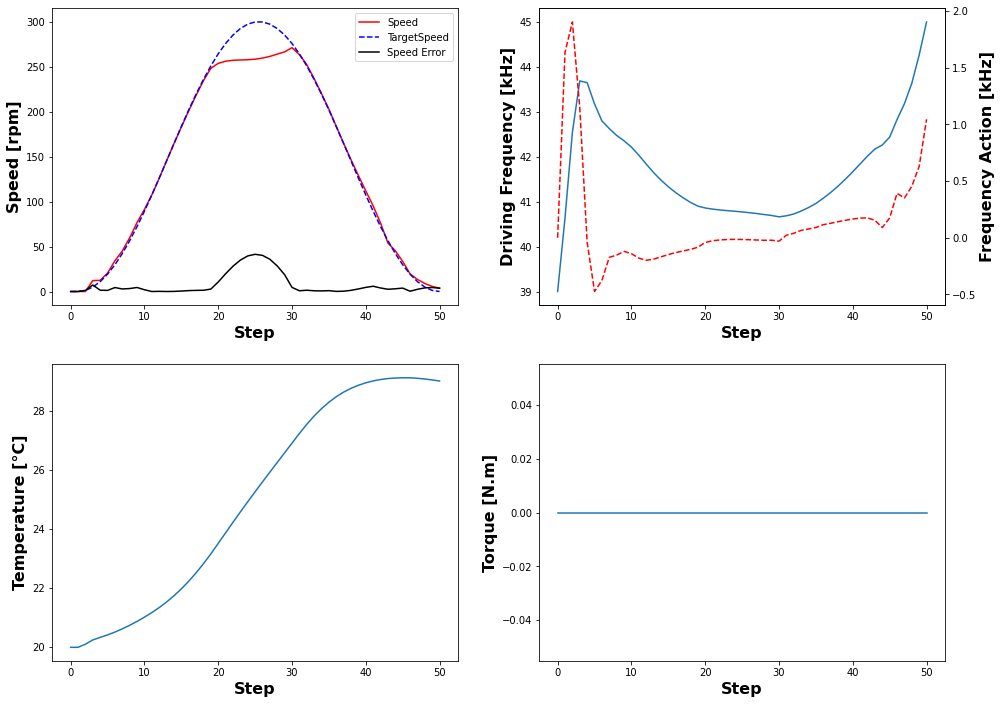

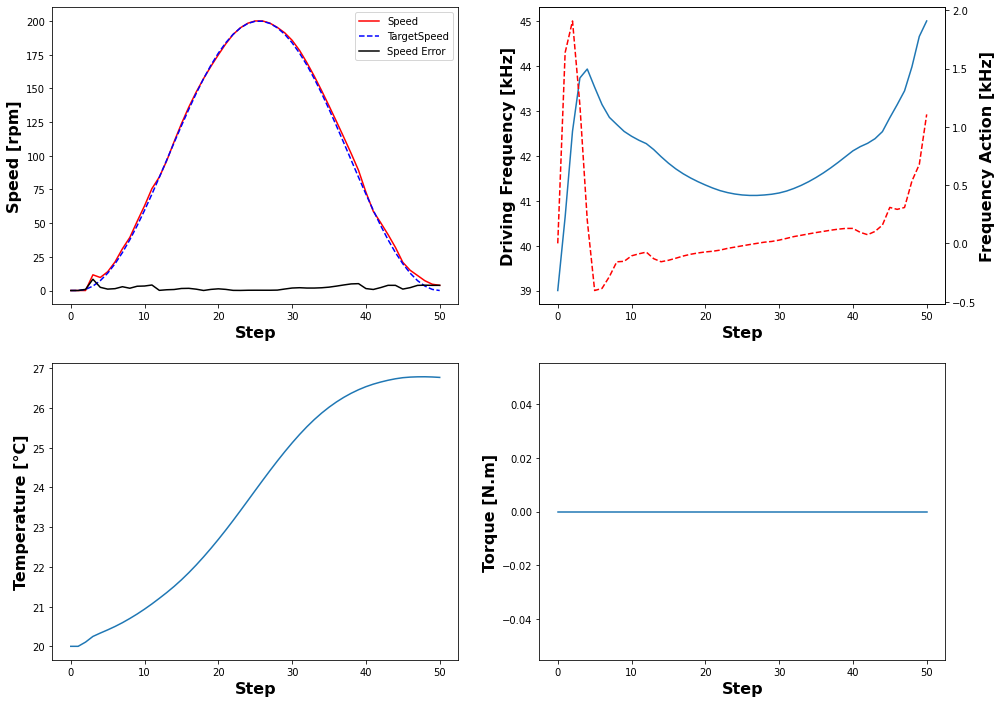

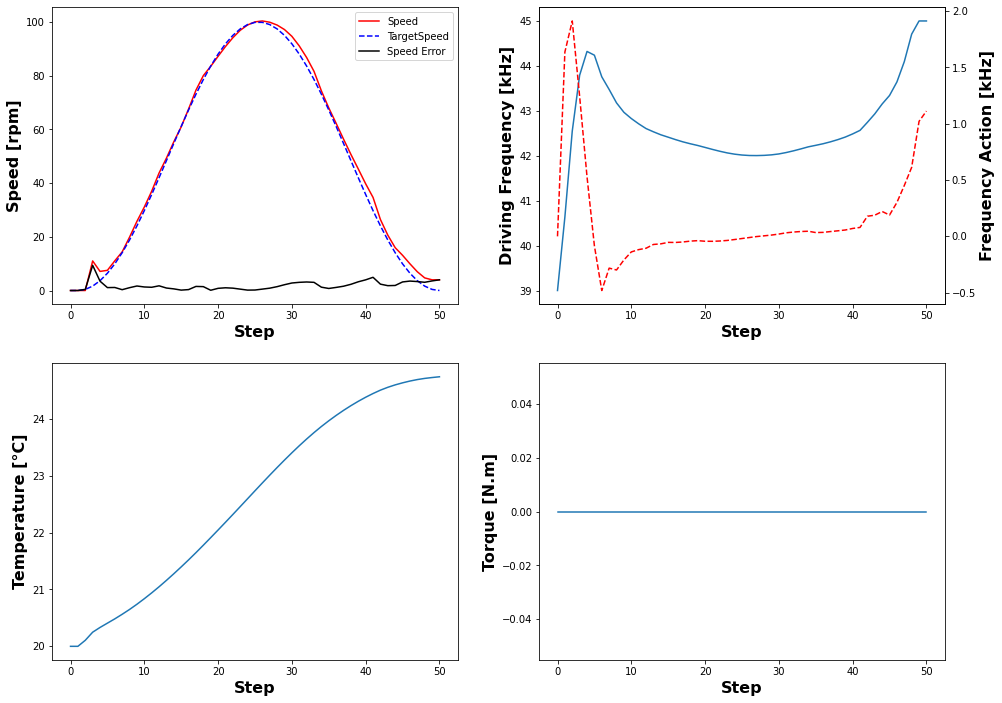

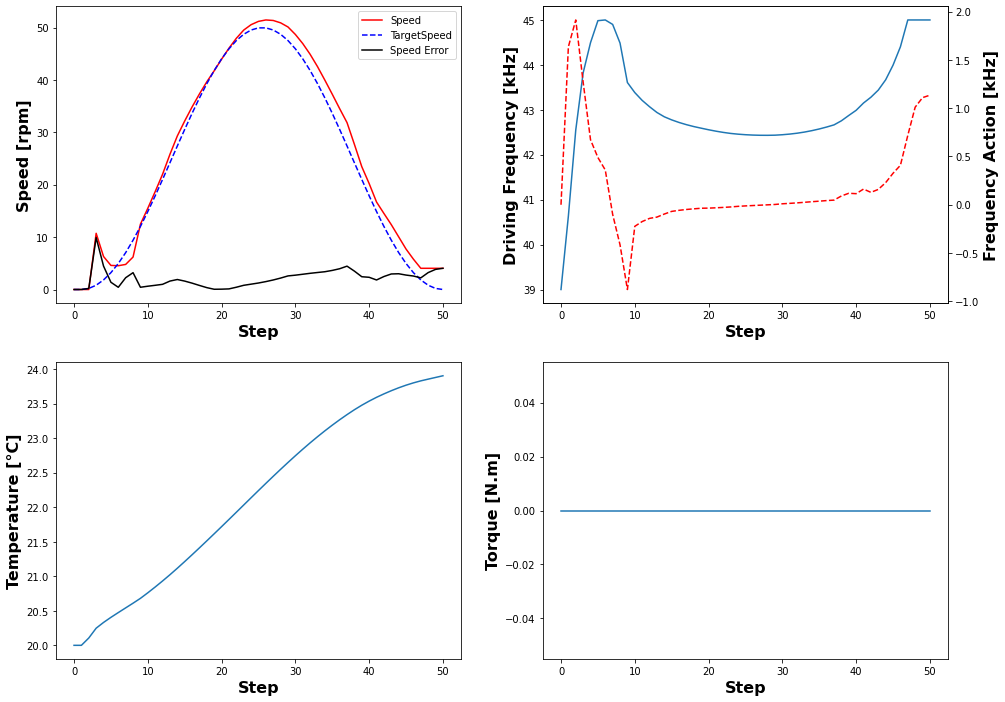

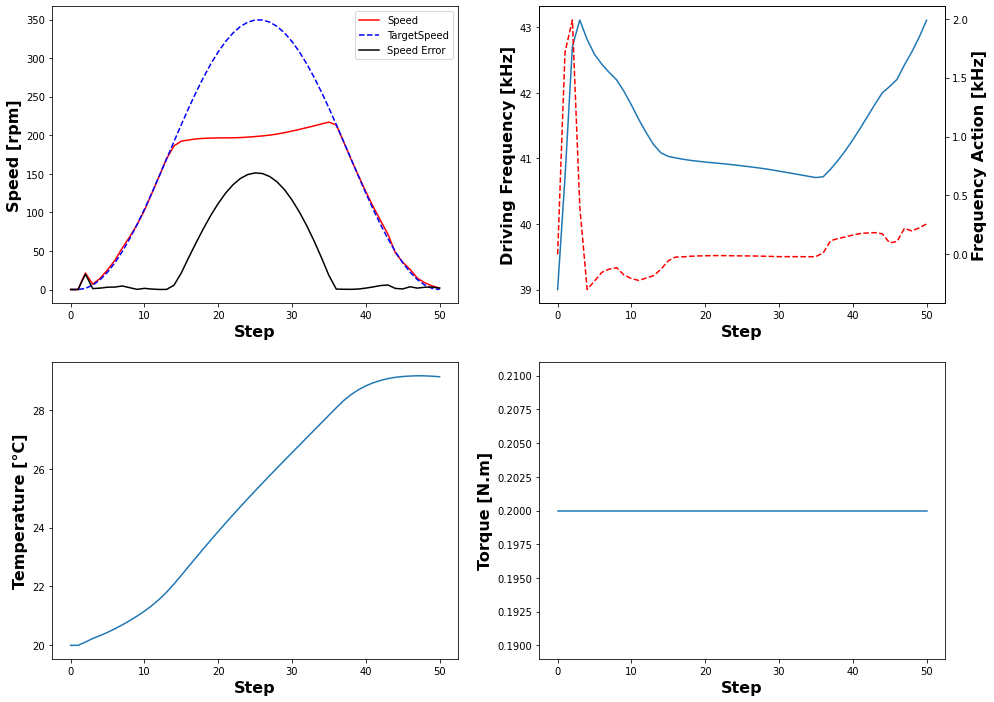

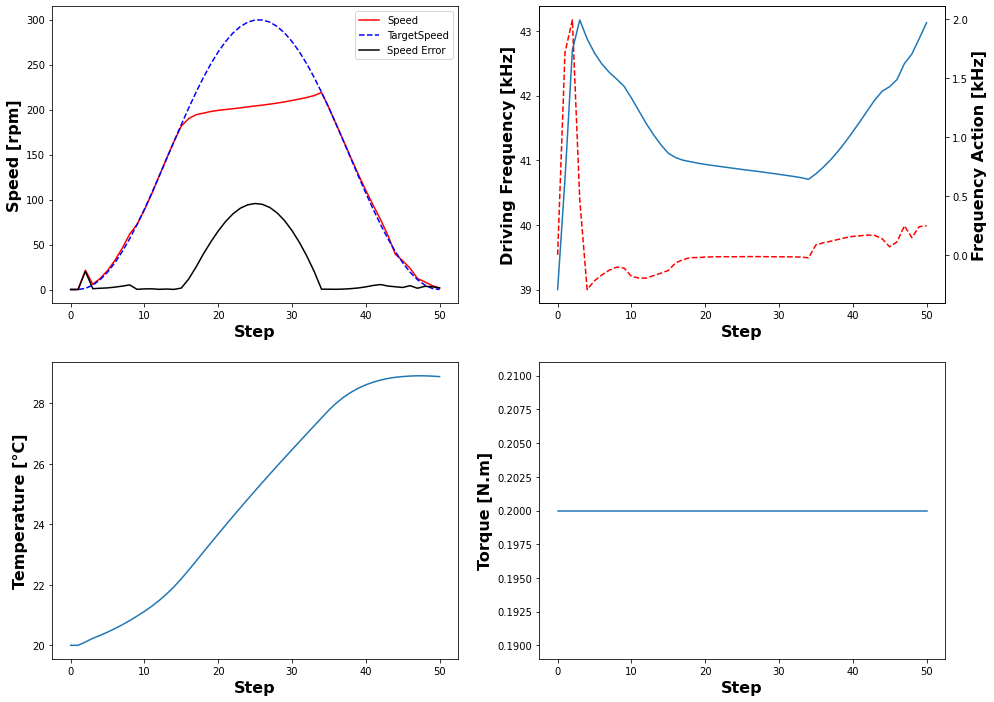

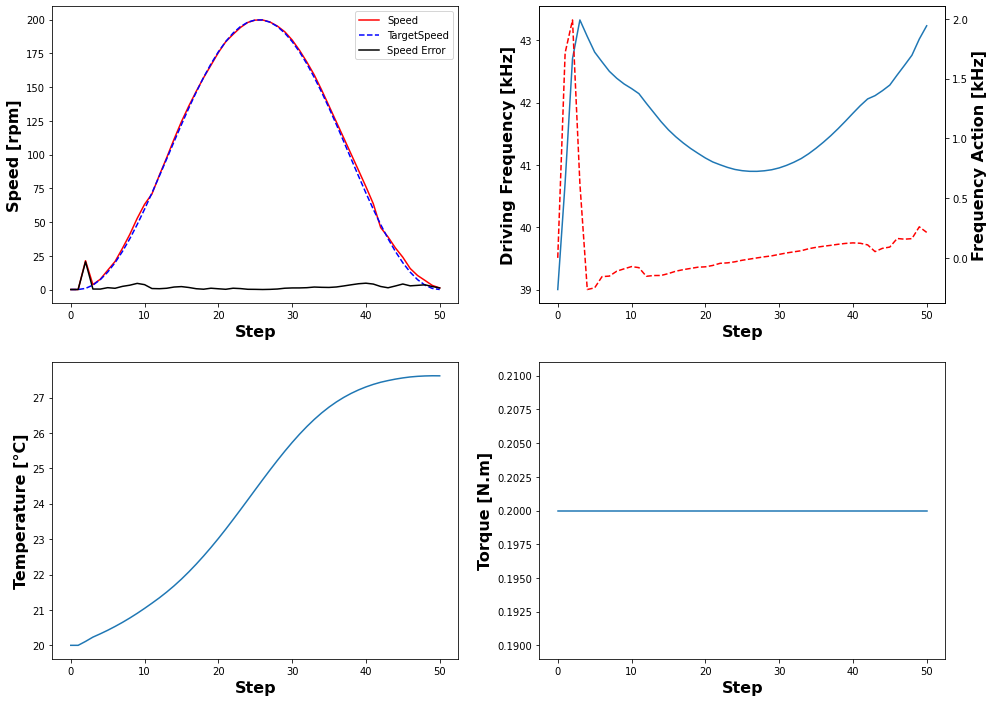

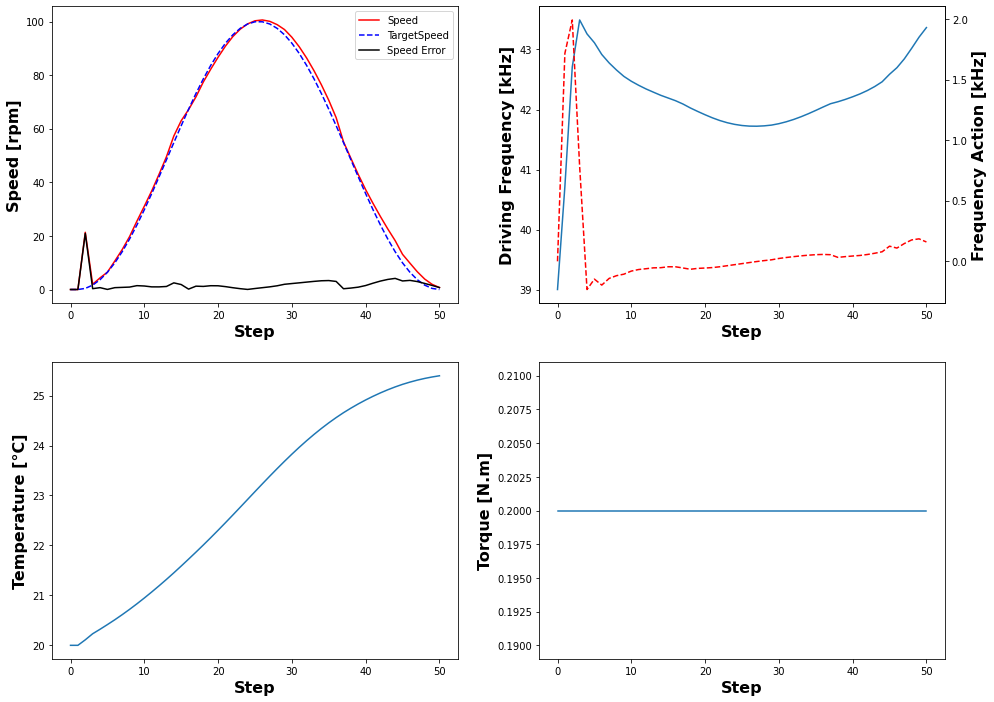

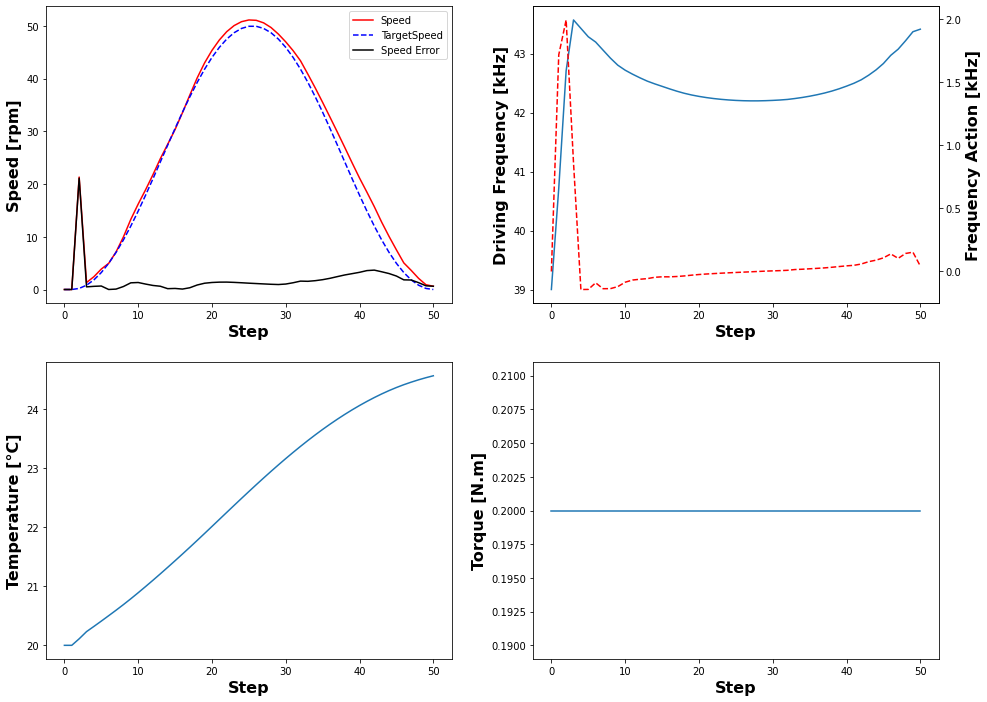

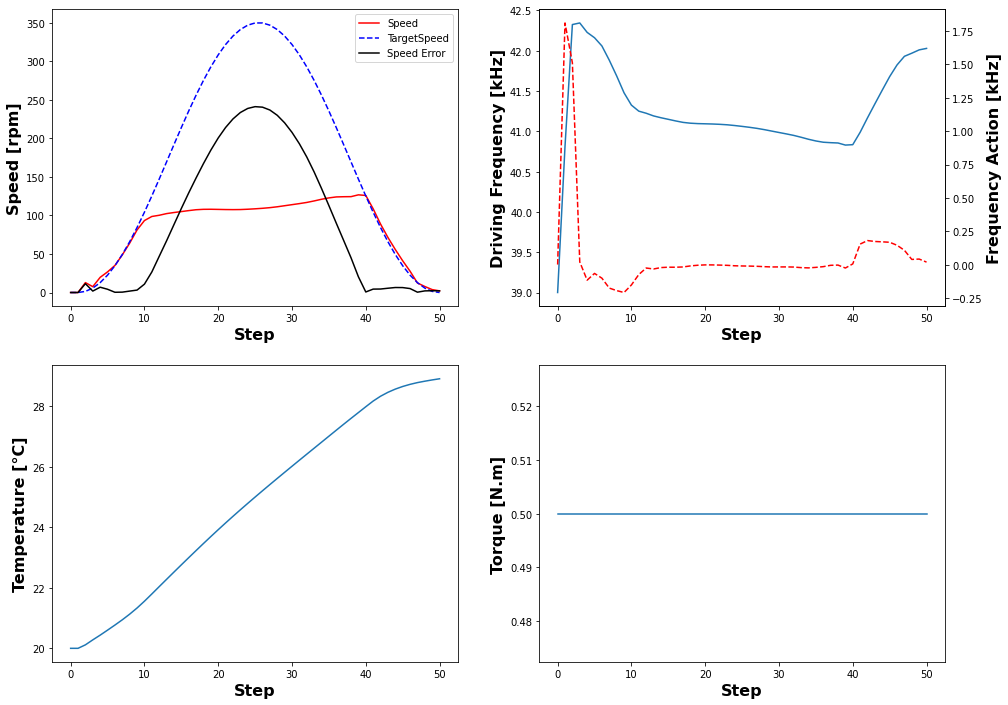

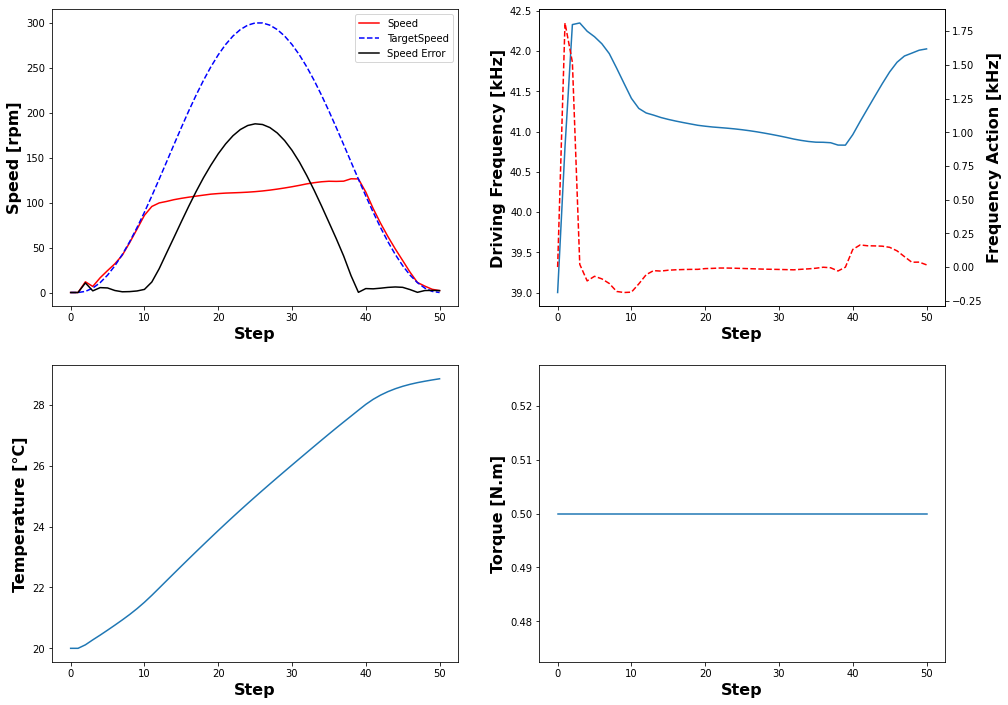

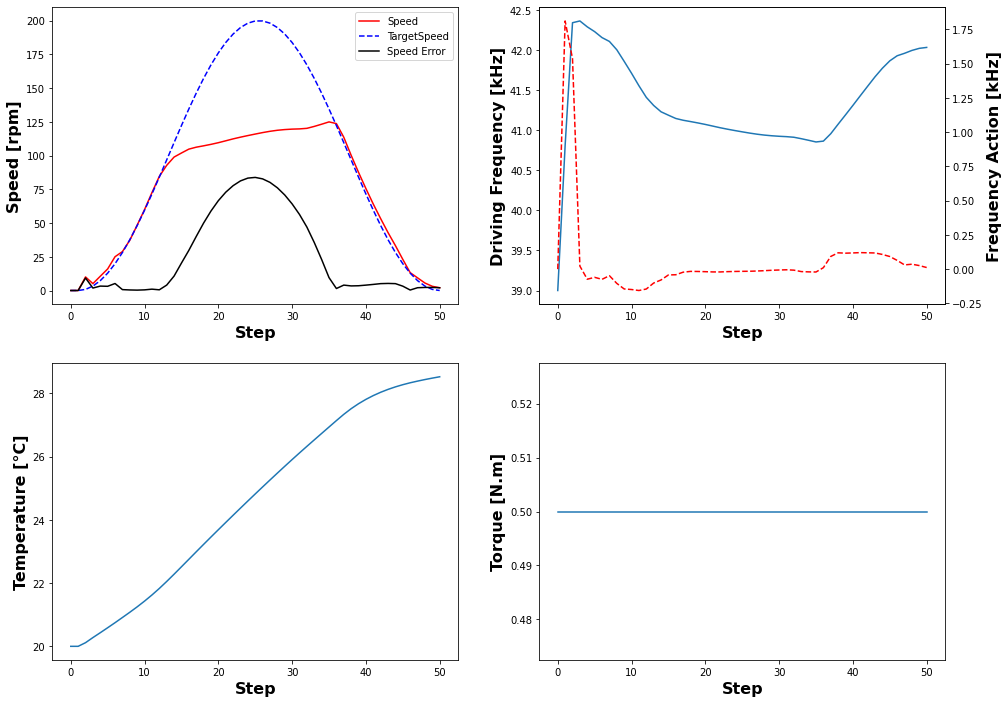

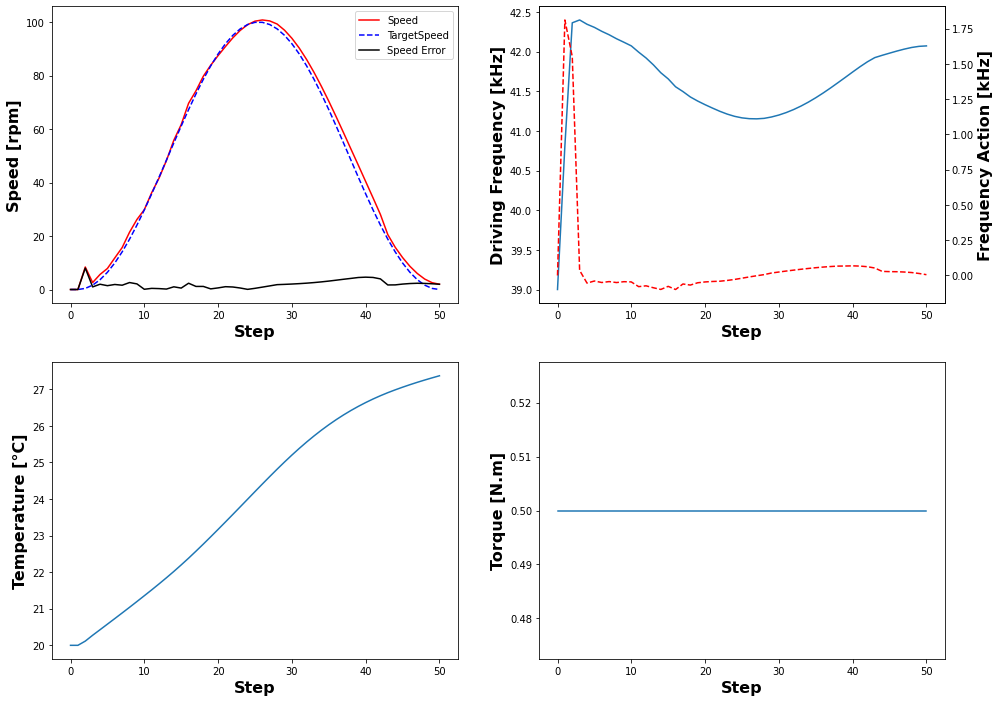

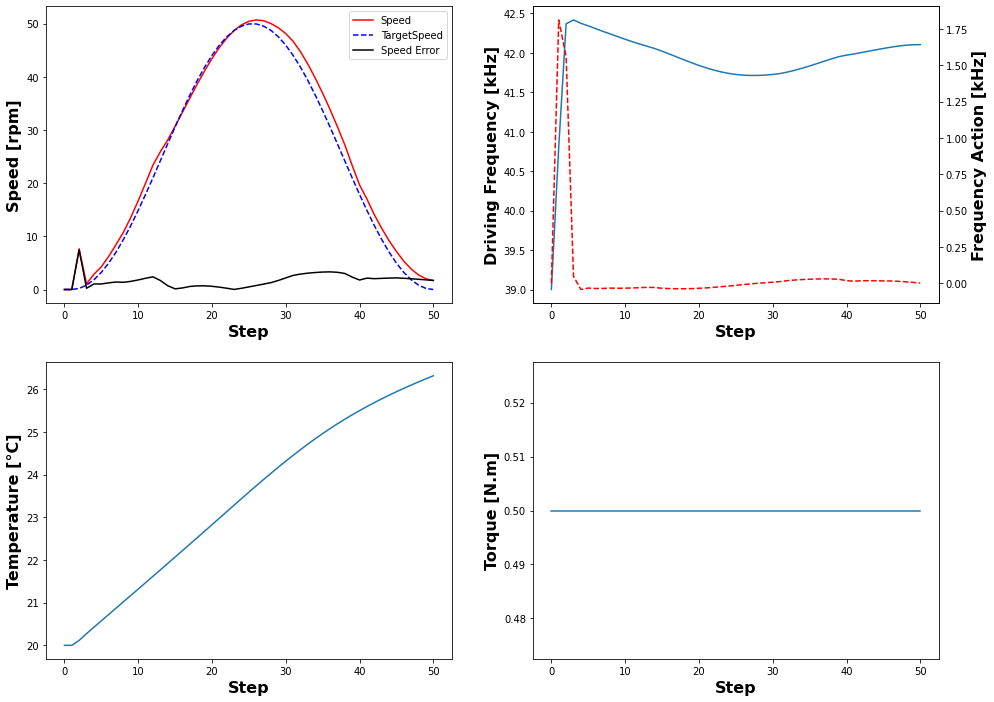

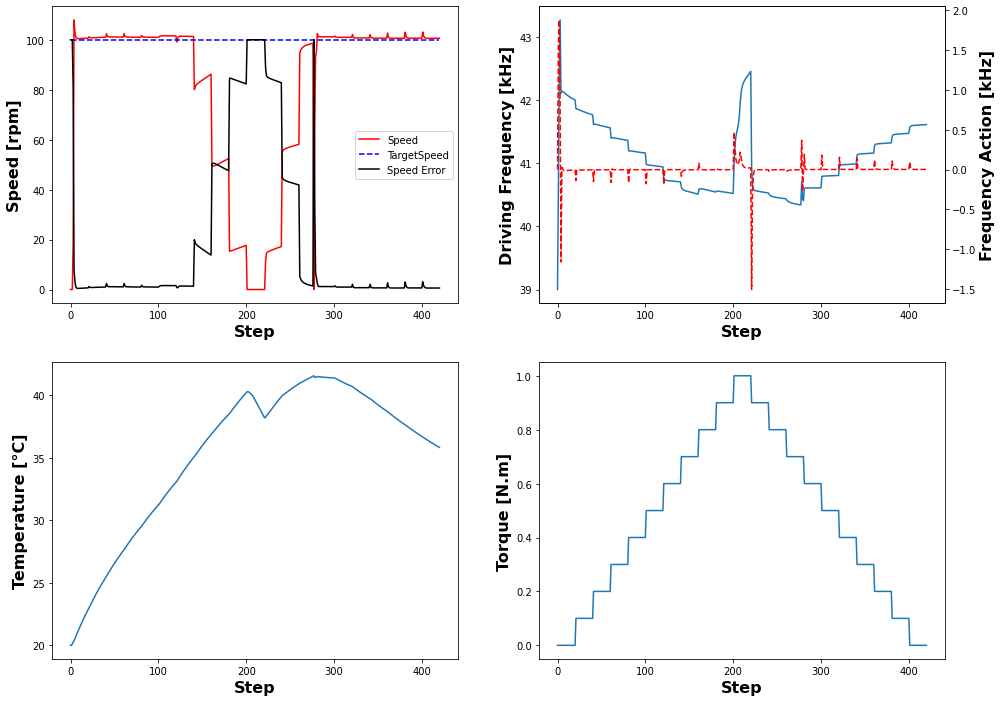

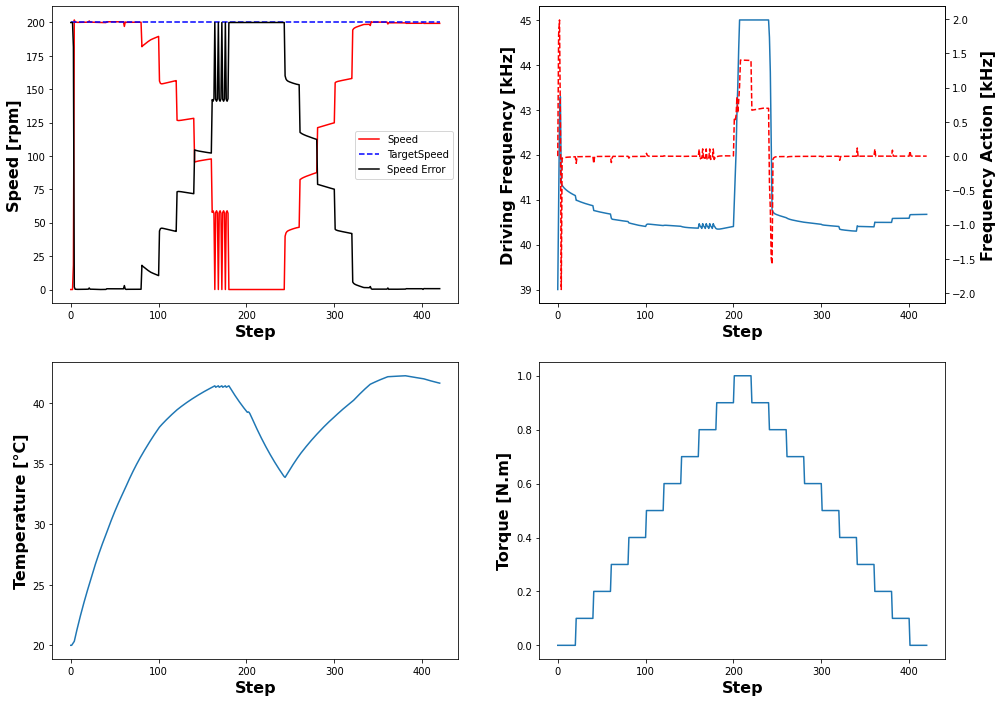

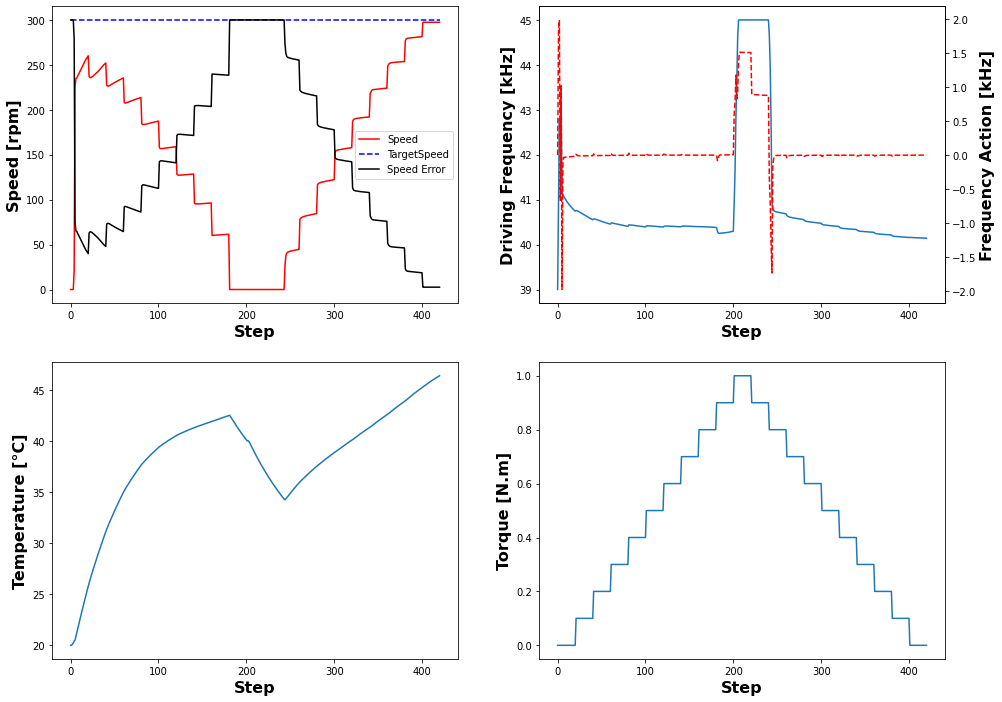

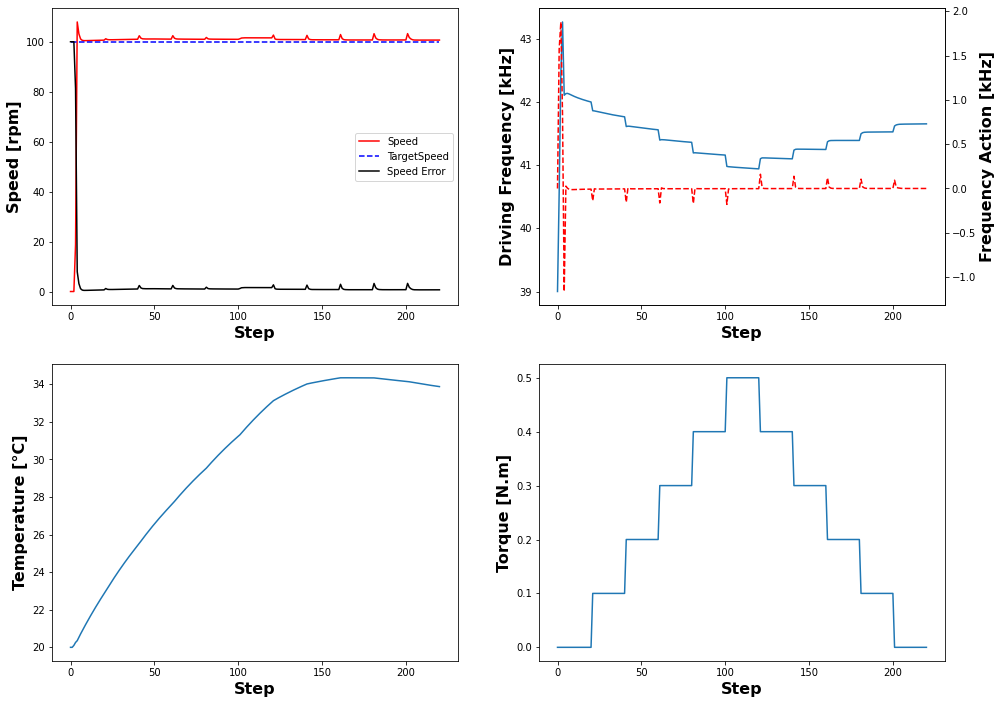

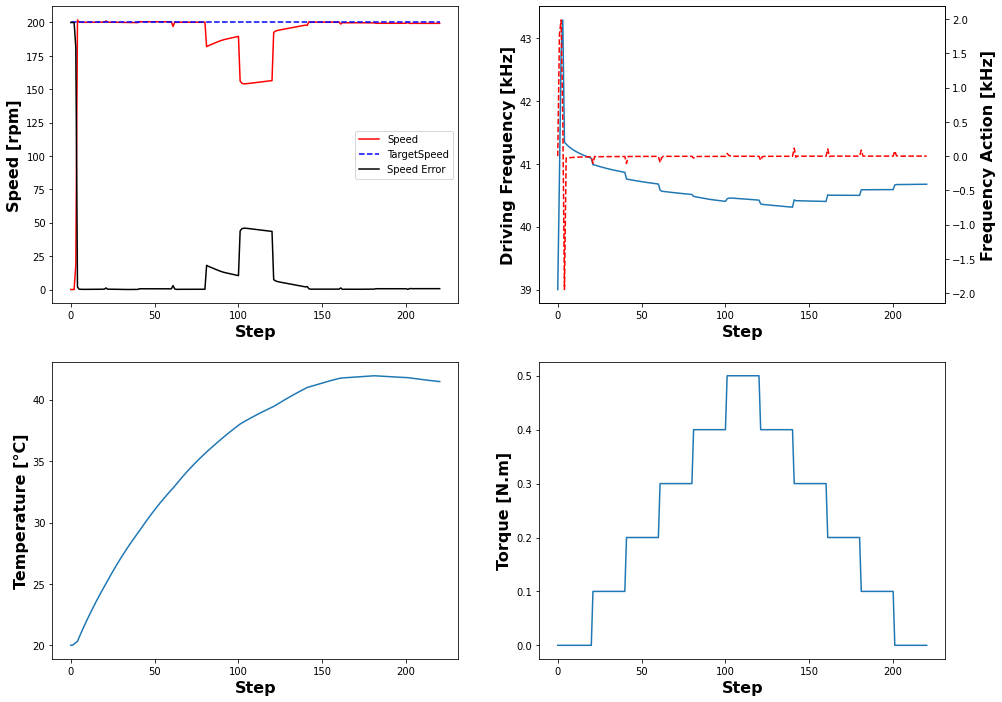

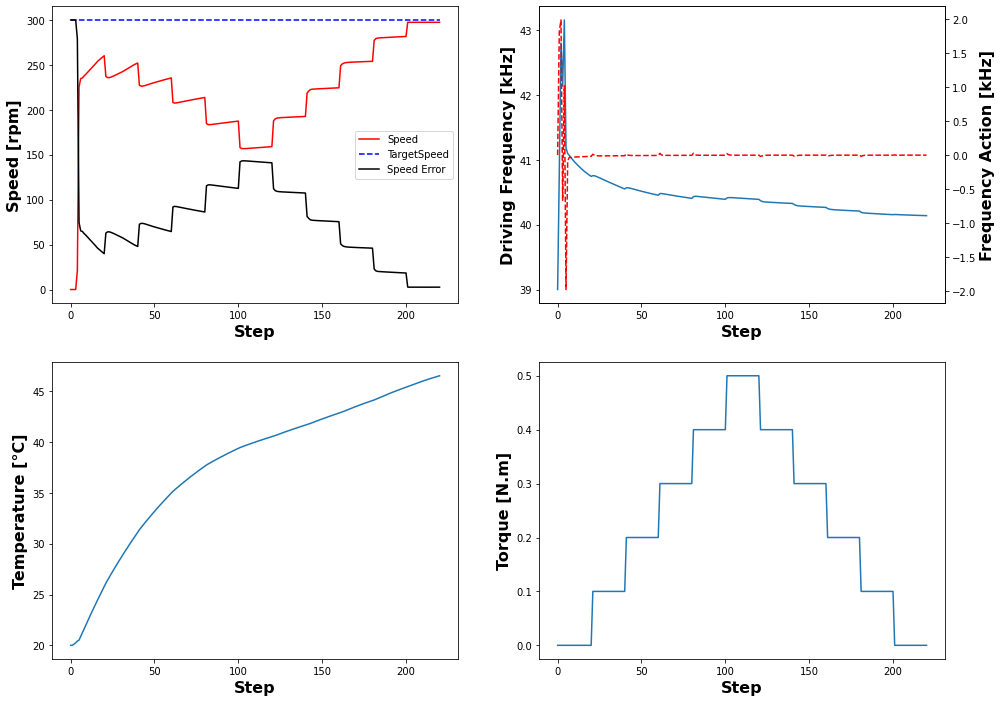

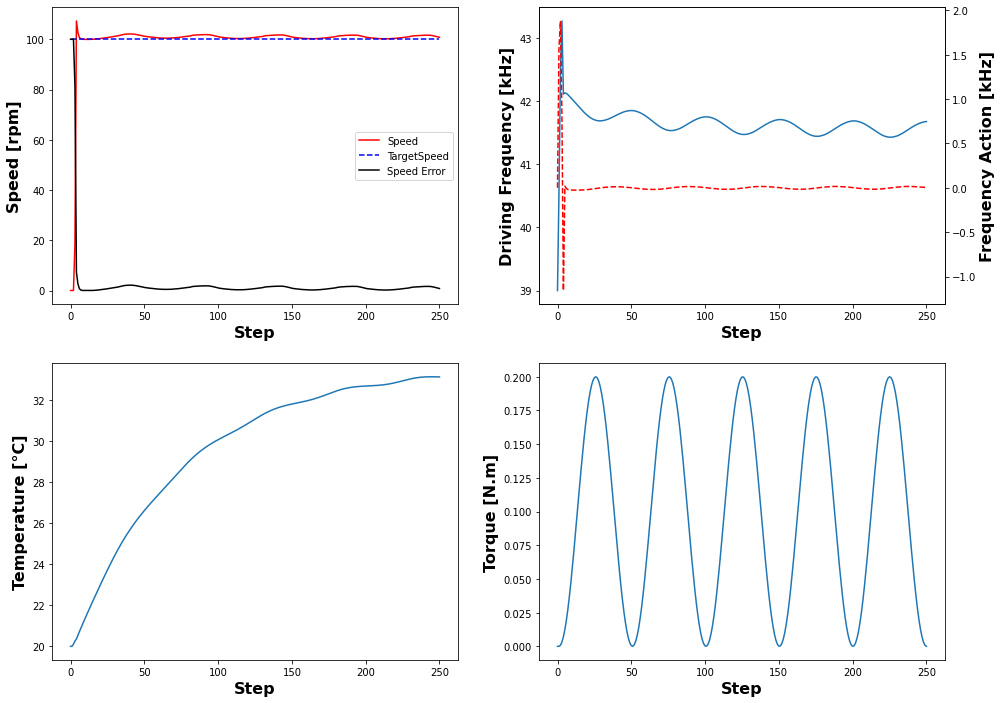

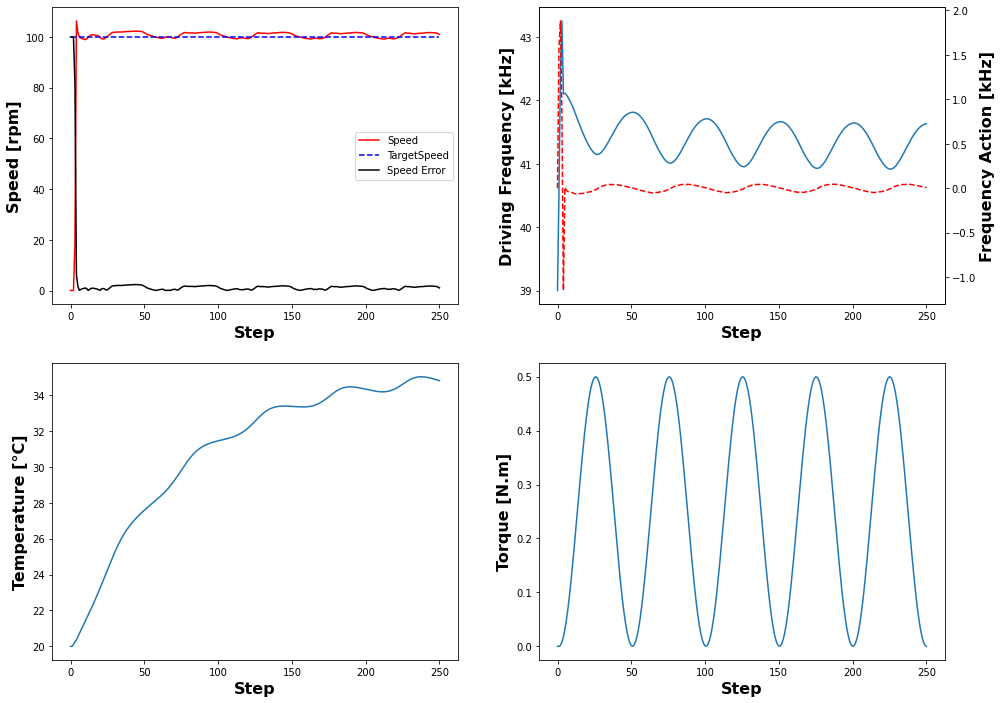

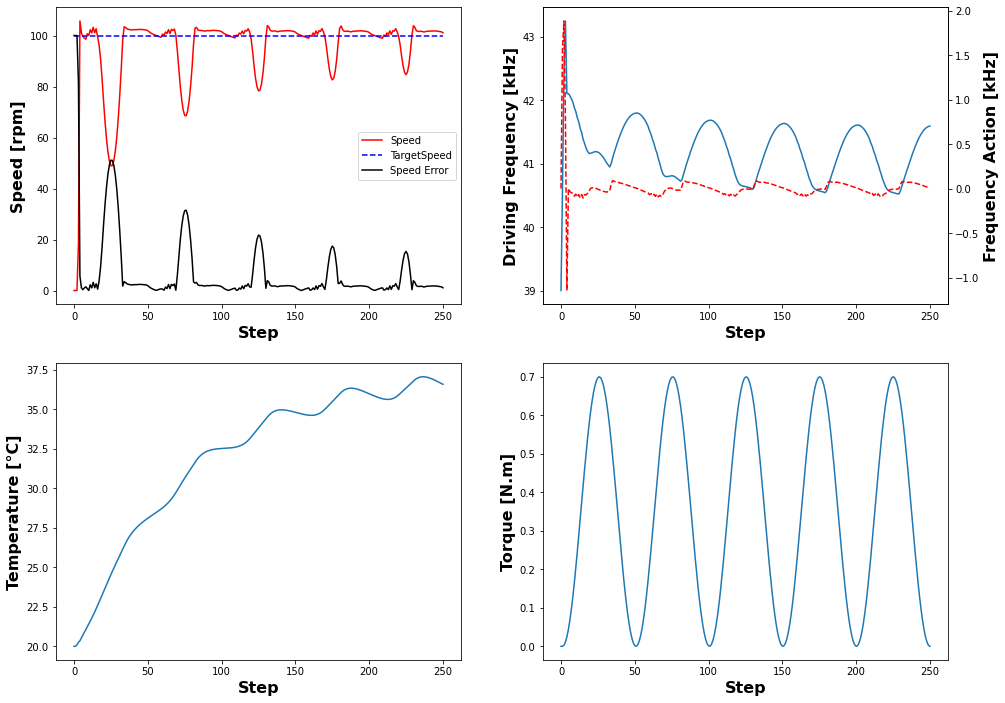

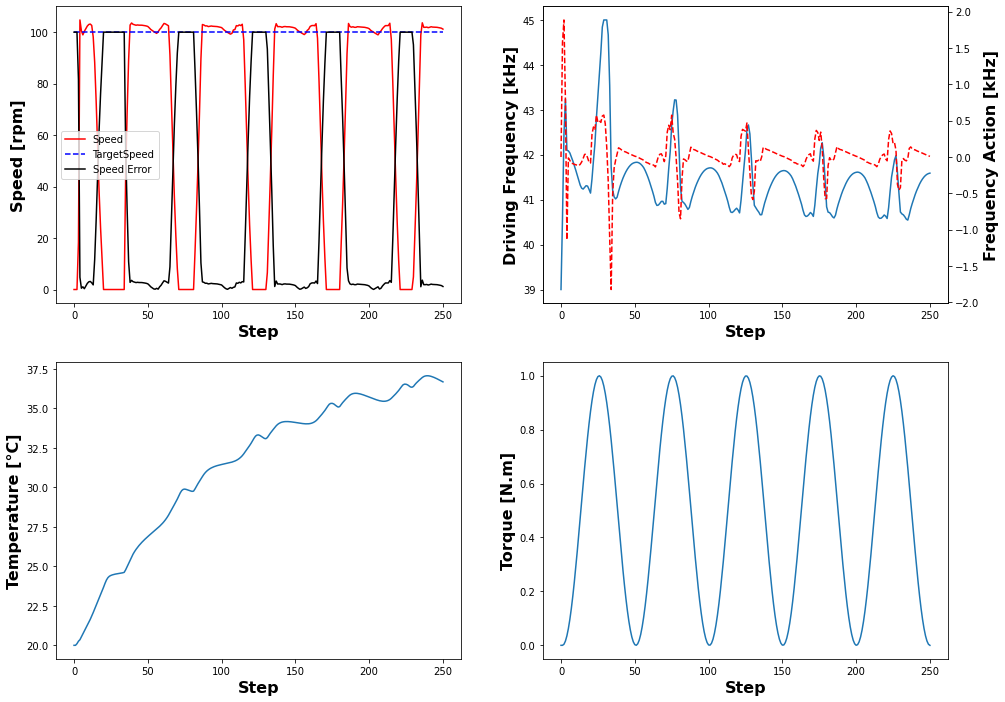

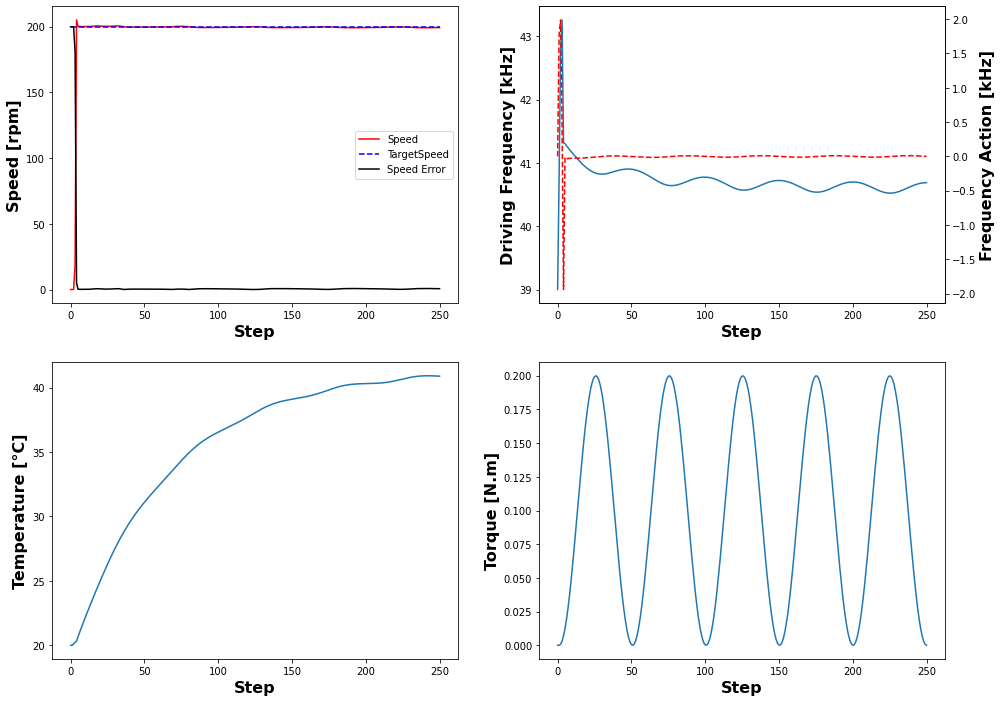

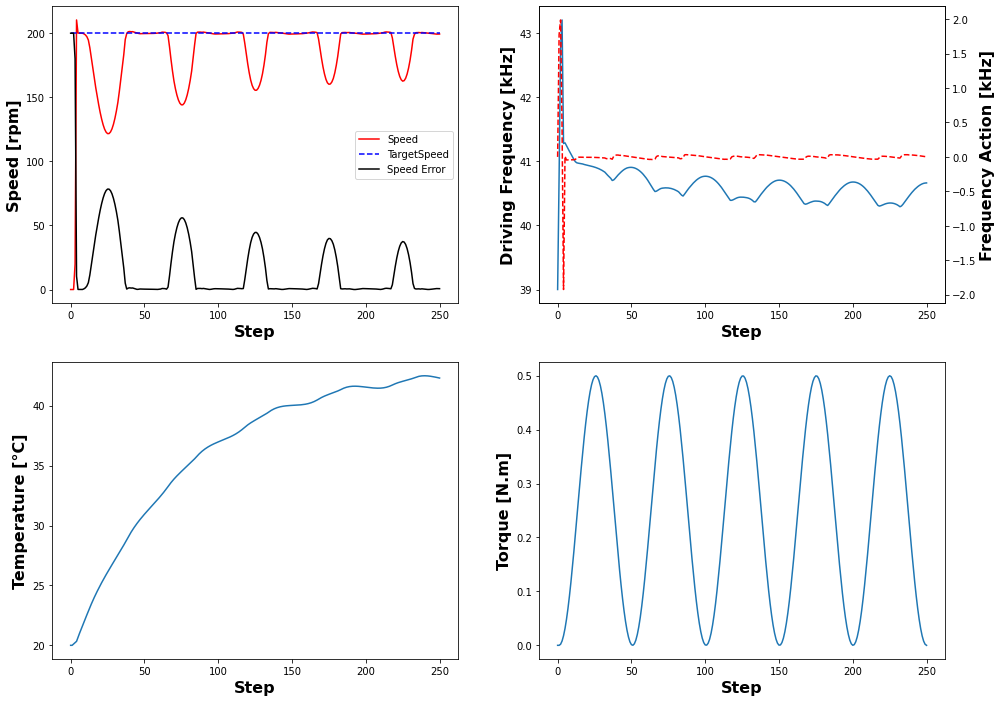

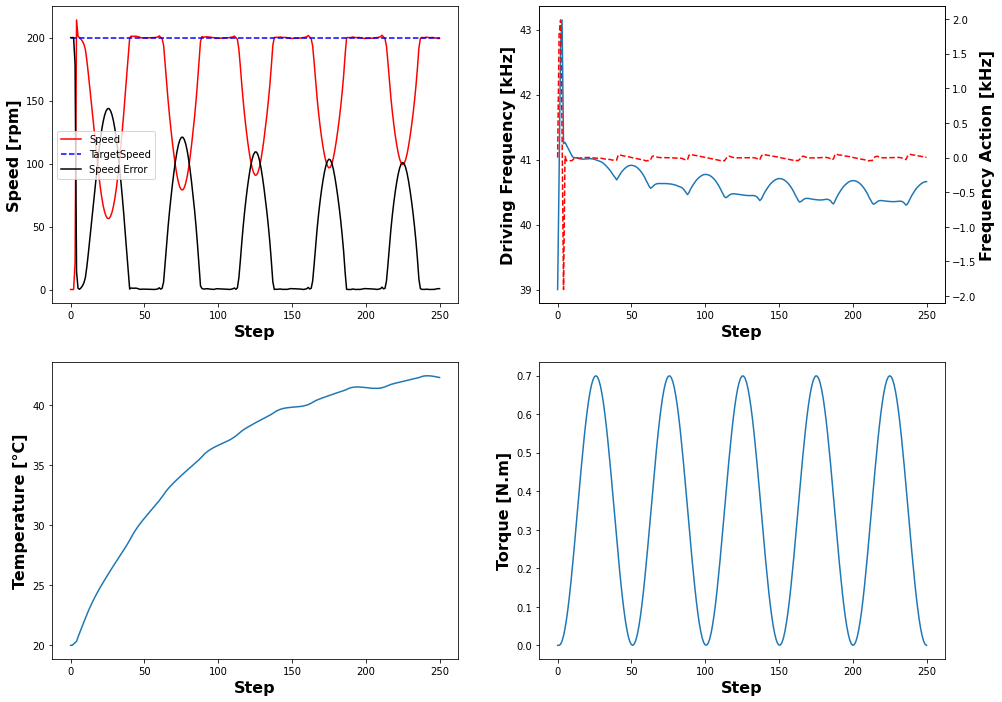

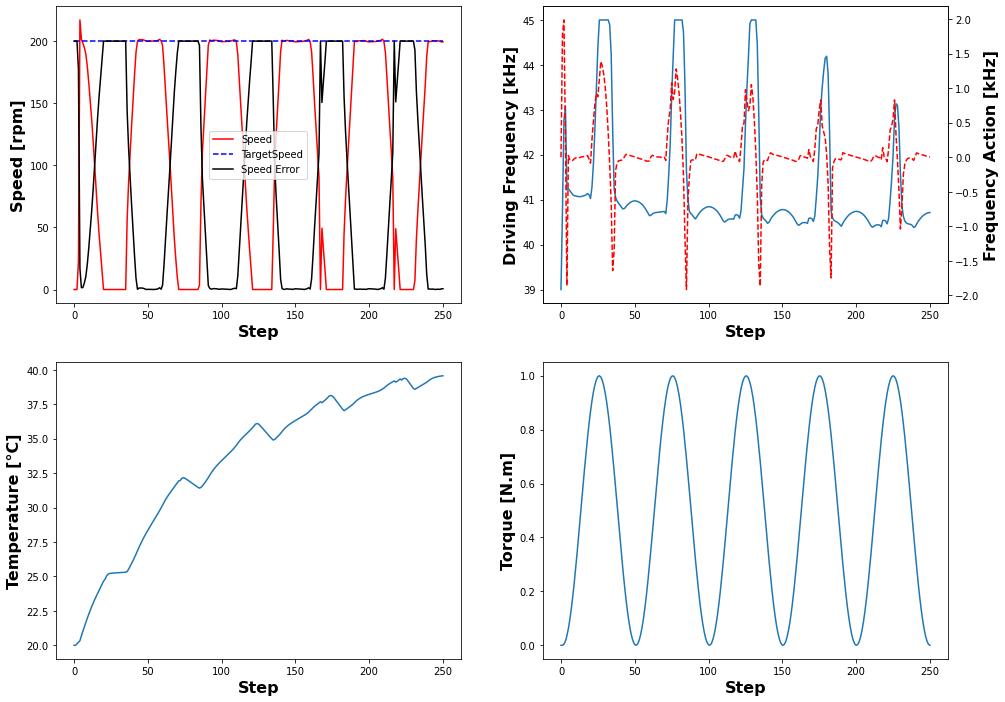

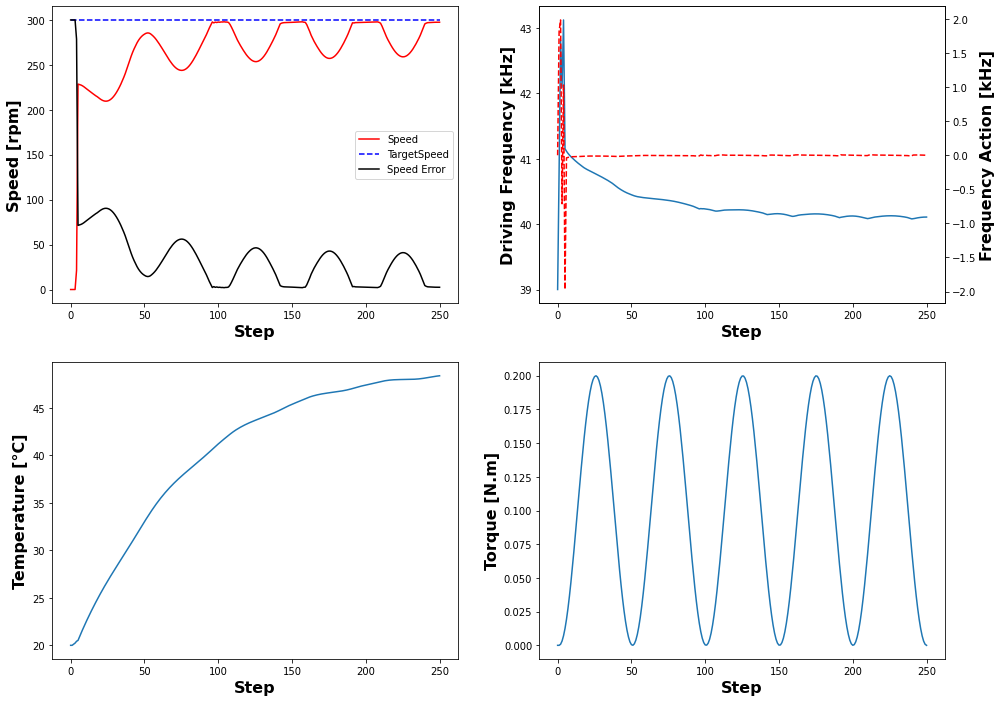

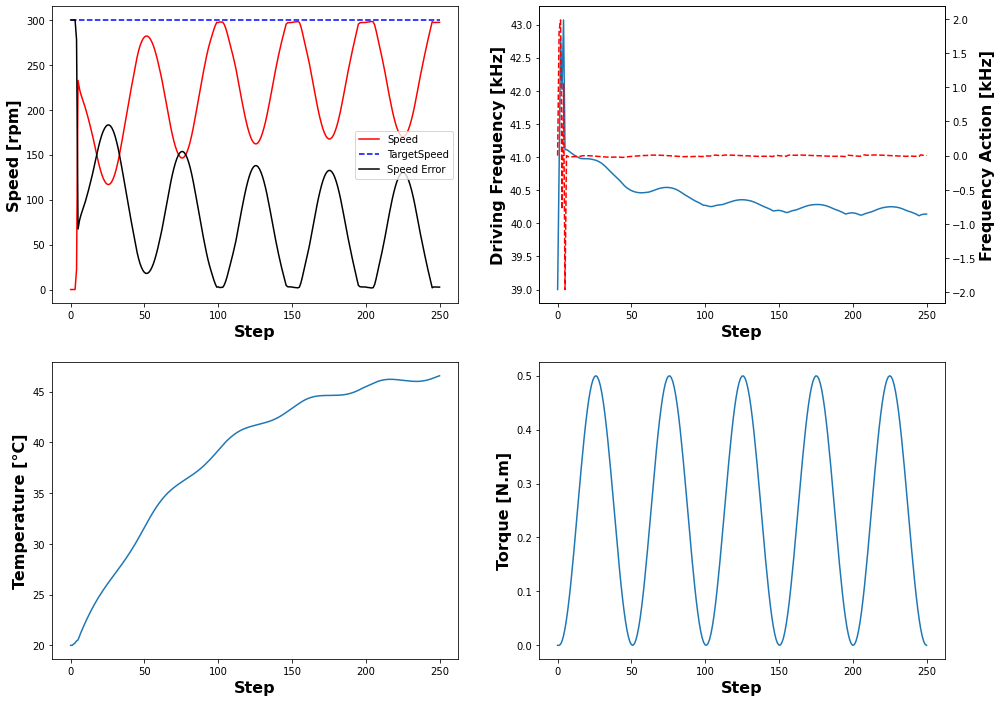

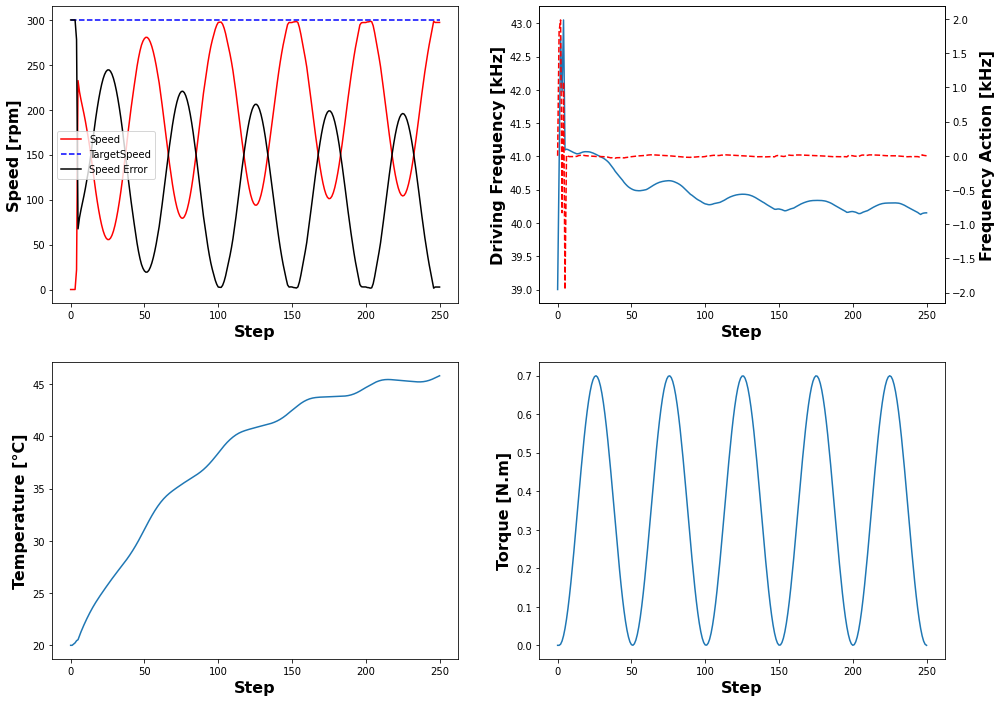

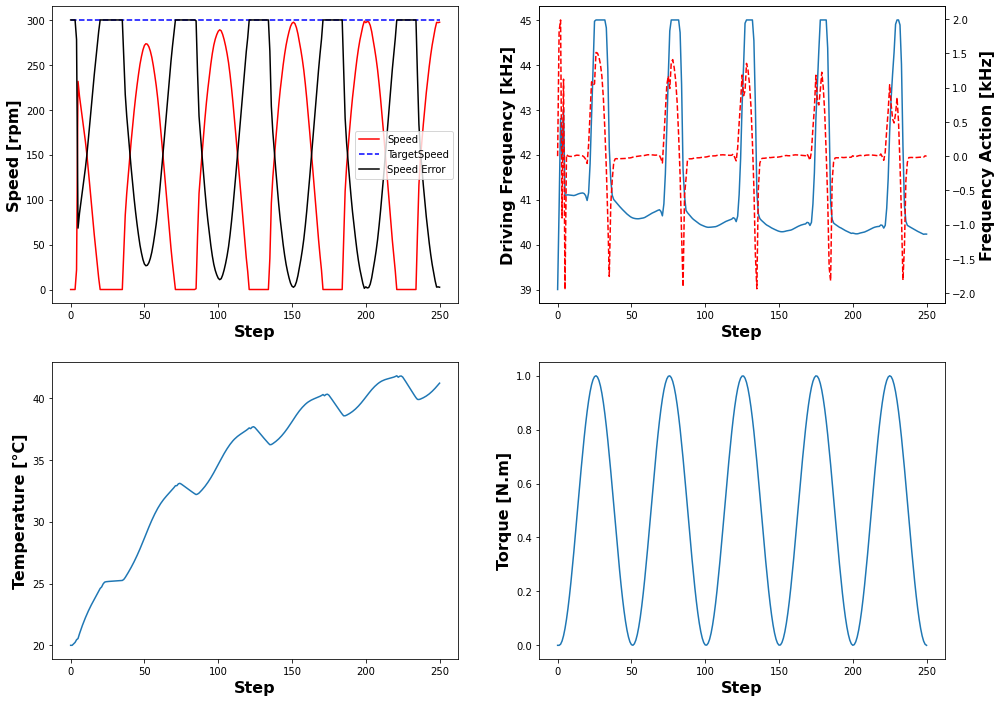

In [ ]:
targetlevels = np.linspace(0,300, 7)
targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
targetSpeeds = []
for level in targetlevels:
    targetSpeeds += [level]*20 
    
for torque in [0,0.2,0.5]:
    speeds = agent.eval_agent(targetSpeeds,torques=[torque]*len(targetSpeeds),freq=39,temp=20)
    #np.savetxt('stepSpeed_300rpm_conTorque_{}Nm_{}.txt'.format(torque,self.env_type), speeds, delimiter=',')

#Sinusoidal Speed
T = 50    #total steps
n = 1      #num cycles
for torque in [0,0.2,0.5]:
    for targSpeed in [175,150,100,50,25]:
        targetSpeeds = targSpeed-targSpeed*np.cos(np.linspace(0,n,T)*2*np.pi)
        speeds = agent.eval_agent(targetSpeeds,torques=[torque]*len(targetSpeeds),freq=39,temp=20)
        #np.savetxt('sinSpeed_{}rpm_conTorque_{}Nm_{}.txt'.format(targSpeed*2,torque,self.env_type), speeds, delimiter=',')

#Step Torque

targetlevels = np.linspace(0,1,11)
targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
torques = []
for level in targetlevels:
    torques += [level]*20 
for targSpeed in [100,200,300]:    
    speeds = agent.eval_agent([targSpeed]*len(torques),torques,freq=39,temp=20)
    #np.savetxt('conSpeed_{}rpm_stepTorque_1Nm_{}.txt'.format(targSpeed,self.env_type), speeds, delimiter=',')

#Step Torque

targetlevels = np.linspace(0,0.5,6)
targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
torques = []
for level in targetlevels:
    torques += [level]*20 
for targSpeed in [100,200,300]:    
    speeds = agent.eval_agent([targSpeed]*len(torques),torques,freq=39,temp=20)
    #np.savetxt('conSpeed_{}rpm_stepTorque_0.5Nm_{}.txt'.format(targSpeed,self.env_type), speeds, delimiter=',')


for targspeed in [100,200,300]:
    for torque in [0.1,0.25,0.35,0.5]:
    #Sinusoidal Torque
        T = 250    #total steps
        n = 5      #num cycles   
        torques = torque-torque*np.cos(np.linspace(0,n,T)*2*np.pi)
        speeds = agent.eval_agent([targspeed]*len(torques),torques,freq=39,temp=20)
        #np.savetxt('conSpeed_{}rpm_sinTorque_{}Nm_{}.txt'.format(torque,targspeed,self.env_type), speeds, delimiter=',')


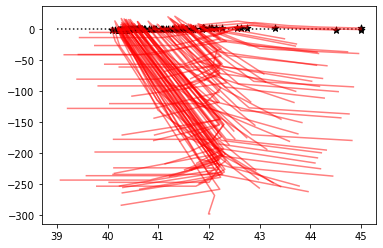

In [ ]:
n = 10
temp = 50
T = 0
plt.plot([39,45],[0,0],'k:',alpha=0.9)
for k in range(100):
  targetSpeed = 300*np.random.random()
  freq =  39 + 6*np.random.random()
  o = agent.env.reset(freq=freq,temp=temp,T=T,targetSpeed=targetSpeed)
  states = [o]
  for i in range(n):
    o = agent.env.set_state(targetSpeed = targetSpeed,torque = T)
    o = agent.scale_obs(o)
    a = agent.get_action(o, deterministic=True)
    o,_,_ = agent.env.step_frequency(a)
    states.append(o)

  states = np.array(states)

  #print(states)
  plt.plot(states[:,0],states[:,3]-states[:,4],'r',alpha=0.5)
  plt.scatter(states[-1,0],states[-1,3]-states[-1,4],marker='*',color='k',s=50)